# HPC Mini-Challenge 2 - Beschleunigung in Data Science
## Teil 2: GPU
#### FHNW - FS2024

Original von S. Suter, angepasst von S. Marcin und M. Stutz

Abgabe von: <font color='blue'>Dominik Filliger</font>

#### Ressourcen
* [Überblick GPU Programmierung](https://www.cherryservers.com/blog/introduction-to-gpu-programming-with-cuda-and-python)
* [CUDA Basic Parts](https://nyu-cds.github.io/python-gpu/02-cuda/)
* [Accelerate Code with CuPy](https://towardsdatascience.com/heres-how-to-use-cupy-to-make-numpy-700x-faster-4b920dda1f56)
* Vorlesungen und Beispiele aus dem Informatikkurs PAC (parallel computing), siehe Ordner "resources"
* CSCS "High-Performance Computing with Python" Kurs, Tag 3: 
    - JIT Numba GPU 1 + 2
    - https://youtu.be/E4REVbCVxNQ
    - https://github.com/eth-cscs/PythonHPC/tree/master/numba-cuda
    - Siehe auch aktuelles Tutorial von 2021
* [Google CoLab](https://colab.research.google.com/) oder ggf. eigene GPU.


In [1]:

import os
import glob
import imageio
import logging
import numpy as np
import cupy as cp
import time
from numba import cuda, vectorize, float32
import matplotlib.pyplot as plt

# TODO REMOVE FOR FINAL SUBMISSION
# logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def load_mri_images(subfolder='001'):
    """Load MRI images from the specified subfolder"""
    try:
        folders = os.path.join('adni_png', subfolder)
        if not os.path.exists(folders):
            raise FileNotFoundError(f"MRI image folder not found: {folders}")
        
        files = sorted(glob.glob(f"{folders}/*.png"))
        if not files:
            raise FileNotFoundError(f"No MRI images found in {folders}")
        
        images = np.array([imageio.imread(f) for f in files], dtype=np.float32)
        names = [f[-17:-4] for f in files]
        logger.info(f"Successfully loaded {len(images)} MRI images from {subfolder}")
        return images, names
    except Exception as e:
        logger.error(f"Error loading MRI images: {str(e)}")
        raise

In [2]:
# Dummy Beispiel zum testen mit Numba

import math
from numba import vectorize
import numpy as np

@vectorize(['float32(float32)'], target='cuda')
def gpu_sqrt(x):
    return math.sqrt(x)
  

a = np.arange(4096,dtype=np.float32)
gpu_sqrt(a)

/home/paperspace/hs24-mc2-dmnkf/.venv/lib/python3.12/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


array([ 0.       ,  1.       ,  1.4142135, ..., 63.97656  , 63.98437  ,
       63.992188 ], dtype=float32)

### 5 GPU Rekonstruktion

Implementiere eine SVD-Rekonstruktionsvariante auf der GPU oder in einem hybriden Setting. Code aus dem ersten Teil darf dabei verwendet werden. Wähle  bewusst, welche Teile des Algorithms in einem GPU Kernel implementiert werden und welche effizienter auf der CPU sind. Ziehe dafür Erkenntnisse aus dem ersten Teil mit ein. Es muss mindestens eine Komponente des Algorithmuses in einem GPU-Kernel implementiert werden. Dokumentiere Annahmen, welche du ggf. zur Vereinfachung triffst. Evaluiere, ob du mit CuPy oder Numba arbeiten möchtest.

Links:
* [Examples: Matrix Multiplikation](https://numba.readthedocs.io/en/latest/cuda/examples.html)

In [3]:
### BEGIN SOLUTION
import math
import numpy as np
import cupy as cp
from numba import cuda
import time
import matplotlib.pyplot as plt
import timeit

# todo 1
def reconstruct_svd_broadcast1(u,s,vt,k):
    ### BEGIN SOLUTION
    reco = u[:,:k] * s[:k] @ vt[:k,:]
    ### END SOLUTION
    return reco

def reconstruct_svd_cp(u, s, vt, k):
    """
    Perform SVD reconstruction using CuPy's built-in dot product.
    """
    return cp.asnumpy(cp.dot(u[:,:k], cp.dot(cp.diag(s[:k]), vt[:k,:])))

def reconstruct_svd_cp_einsum(u, s, vt, k):
    """
    Perform SVD reconstruction using CuPy and einsum for matrix multiplication.
    """
    return cp.asnumpy(cp.einsum('ik,k,kj->ij', u[:,:k], s[:k], vt[:k,:]))

def reconstruct_svd_cp_broadcast(u, s, vt, k):
    """
    CuPy SVD reconstruction using broadcasting for the multiplication of S.
    """
    return cp.asnumpy(cp.dot(u[:,:k], cp.multiply(s[:k].reshape(-1, 1), vt[:k,:])))

@cuda.jit
def reconstruct_svd_kernel(u, s, vt, out, k):
    """
    CUDA kernel that reconstructs a matrix from SVD components:
      out = u * s * vt, up to rank k.
    """
    i, j = cuda.grid(2)
    if i < u.shape[0] and j < vt.shape[1]:
        tmp = 0.0
        for r in range(k):
            tmp += u[i, r] * s[r] * vt[r, j]
        out[i, j] = tmp

def reconstruct_svd_numba(u, s, vt, k):
    """
    Multiply U, S, and V^T on the GPU using a custom CUDA kernel.
    """
    U_k = u[:,:k]
    S_k = s[:k]
    VT_k = vt[:k,:]

    # Prepare output on GPU
    out = np.zeros((U_k.shape[0], VT_k.shape[1]), dtype=np.float32)

    # Launch kernel
    threads_per_block = (16, 16)
    blocks_per_grid = (
        math.ceil(U_k.shape[0] / threads_per_block[0]),
        math.ceil(VT_k.shape[1] / threads_per_block[1])
    )
    reconstruct_svd_kernel[blocks_per_grid, threads_per_block](U_k, S_k, VT_k, out, S_k.shape[0])
    return out

### END SOLUTION

/tmp/ipykernel_57132/2554584275.py:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = np.array([imageio.imread(f) for f in files], dtype=np.float32)


/home/paperspace/hs24-mc2-dmnkf/.venv/lib/python3.12/site-packages/numba/cuda/cudadrv/devicearray.py:888: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


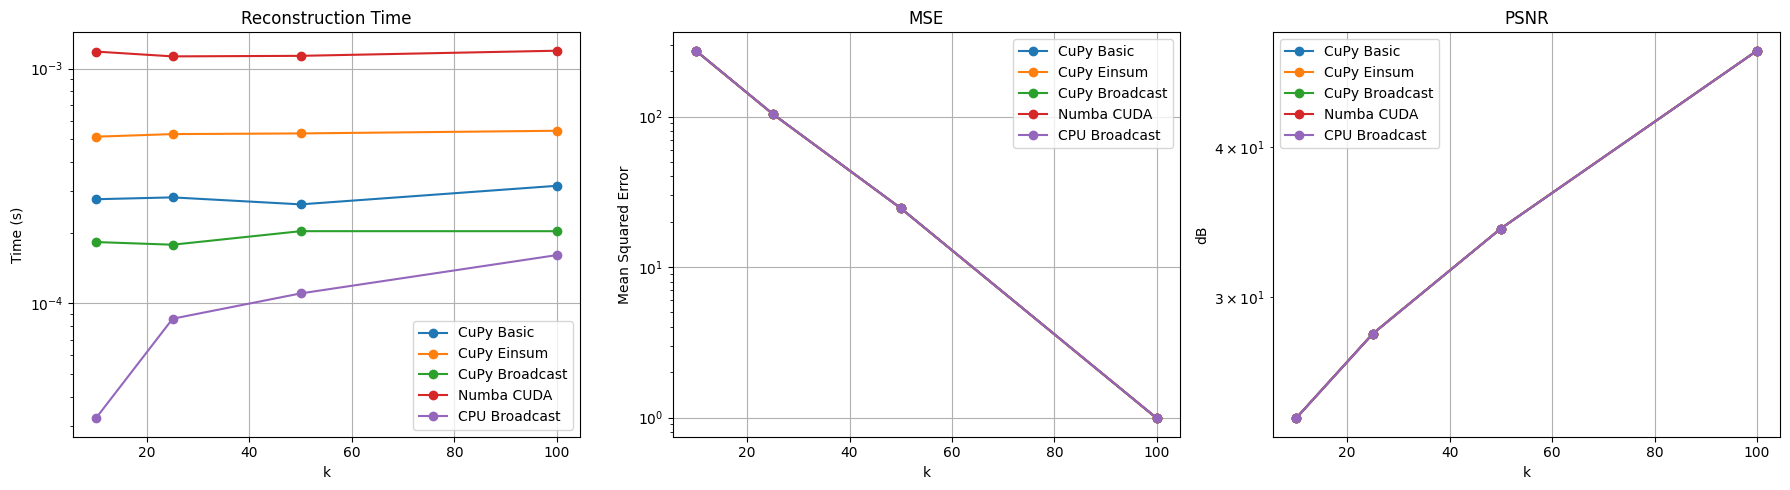

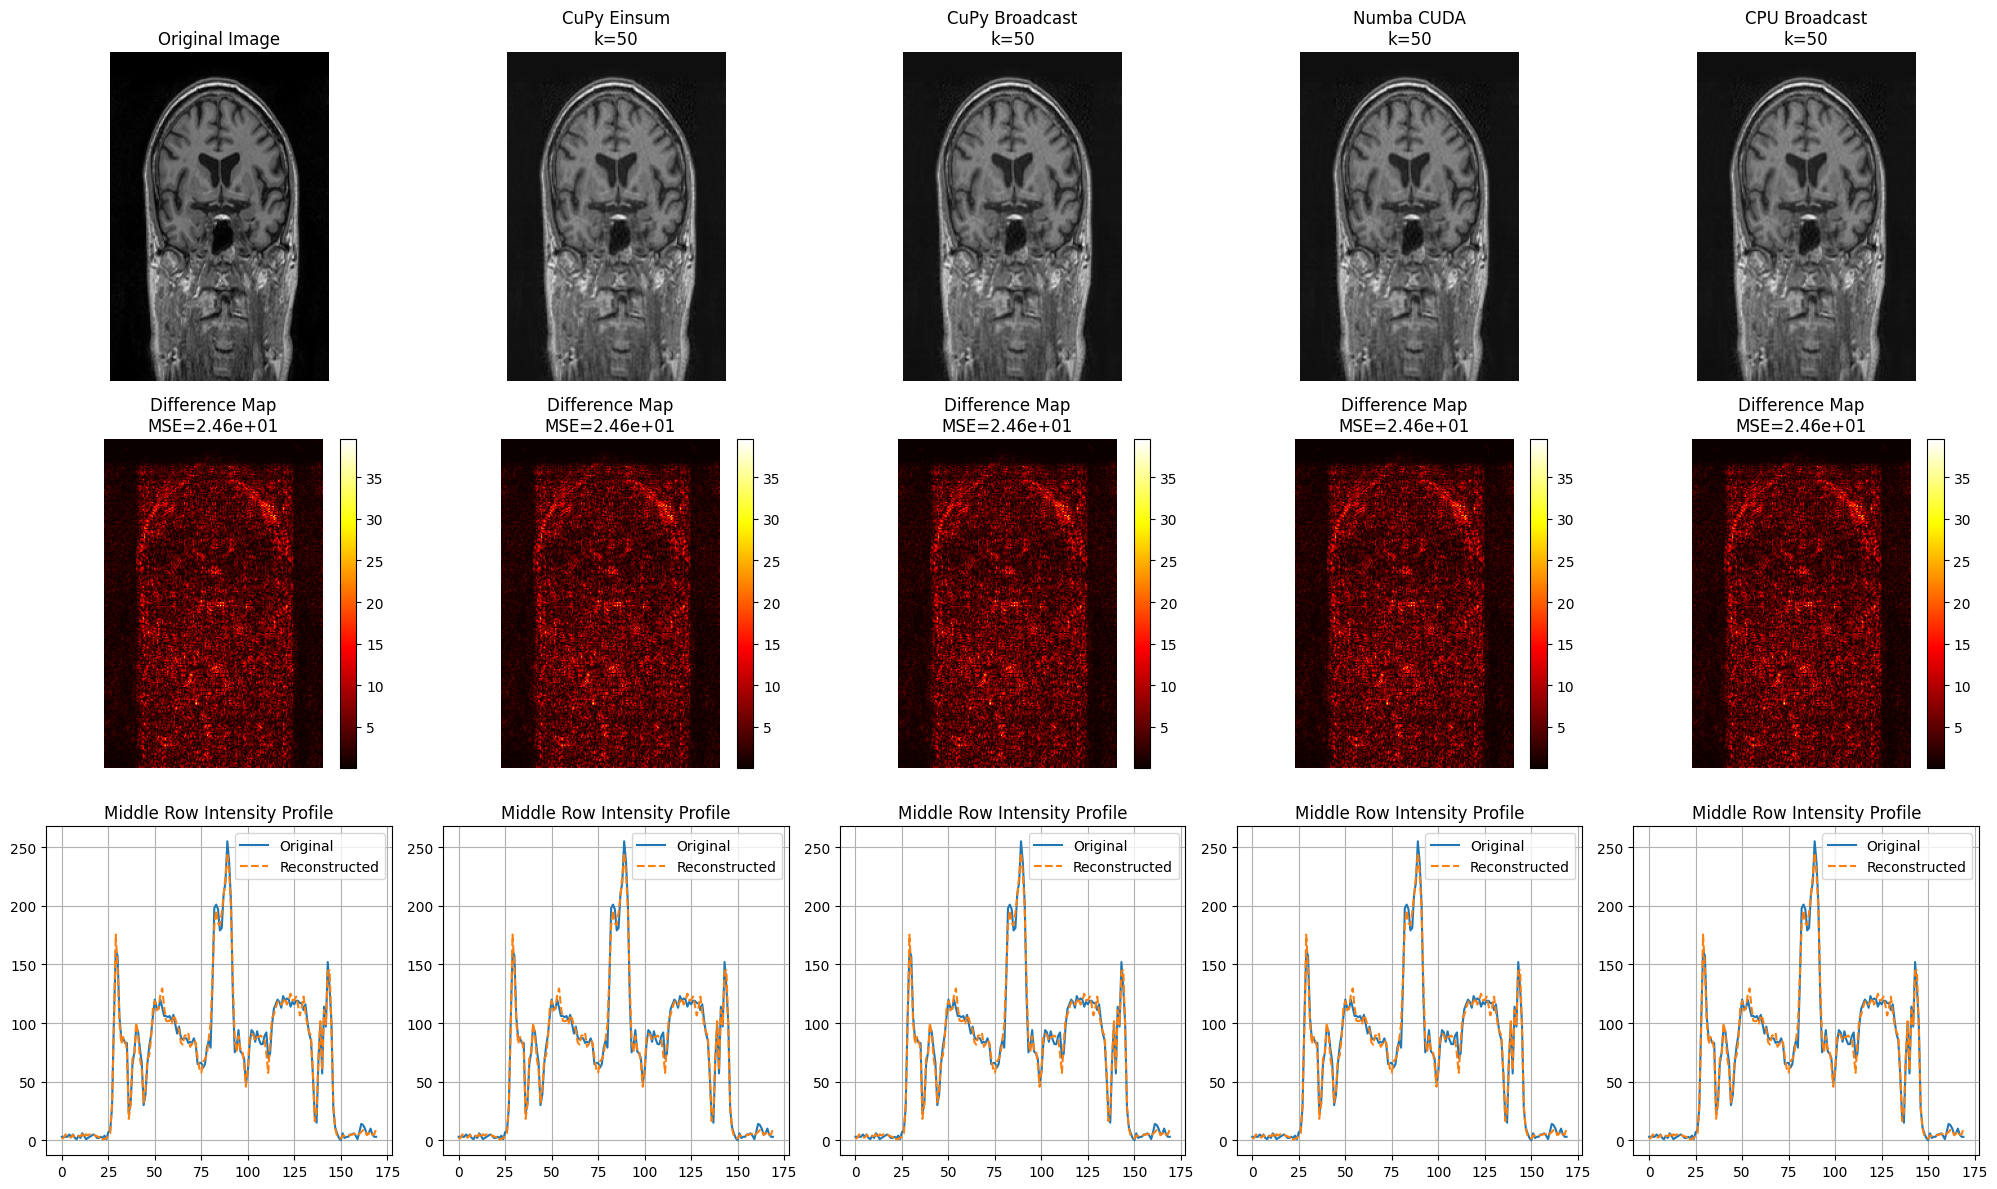

In [4]:

def measure_metrics(original, reconstructed):
    """
    Compute MSE and PSNR for the given original and reconstructed images.
    """
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:  # Perfect reconstruction
        psnr = float('inf')
    else:
        psnr = round(20 * np.log10(255.0 / np.sqrt(mse)), 5)
    return mse, psnr

def plot_reconstruction_comparison(test_image, k_values=(10, 25, 50, 100)):
    """
    For each method, reconstruct the test_image with various k-values,
    measuring decomposition and reconstruction times separately.
    """
    implementations = {
        'CuPy Basic': reconstruct_svd_cp,
        'CuPy Einsum': reconstruct_svd_cp_einsum,
        'CuPy Broadcast': reconstruct_svd_cp_broadcast,
        'Numba CUDA': reconstruct_svd_numba,
        'CPU Broadcast': reconstruct_svd_broadcast1,
    }

    results = {name: [] for name in implementations}

    # Perform SVD decomposition once
    U, S, VT = np.linalg.svd(test_image, full_matrices=False)

    # Pre-transfer data to GPU for GPU implementations
    U_gpu = cp.asarray(U, dtype=cp.float32)
    S_gpu = cp.asarray(S, dtype=cp.float32)
    VT_gpu = cp.asarray(VT, dtype=cp.float32)

    for k in k_values:
        first_mse = None
        first_psnr = None
        
        for name, func in implementations.items():
            recon_times, mse_list, psnr_list = [], [], []
            
            # Prepare inputs based on implementation type
            if name == 'CPU Broadcast':
                u_input, s_input, vt_input = U, S, VT
            else:
                u_input, s_input, vt_input = U_gpu, S_gpu, VT_gpu
                # warmup
                func(u_input, s_input, vt_input, k)

            recon_time = timeit.timeit(
                lambda: func(u_input, s_input, vt_input, k),
                number=1000
            ) / 1000
            reconstructed = func(u_input, s_input, vt_input, k)
            
            mse, psnr = measure_metrics(test_image, reconstructed)
            
            # Store first MSE/PSNR values to compare against
            if first_mse is None:
                first_mse = mse
            else:
                # Assert that MSE and PSNR are equal across implementations
                assert np.allclose(mse, first_mse, rtol=1e-5), f"MSE mismatch for {name}"

            results[name].append({
                'k': k,
                'recon_time': recon_time,
                'mse': mse,
                'psnr': psnr,
                'reconstructed': reconstructed
            })

    # Plot reconstruction time, MSE, PSNR
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for name, data in results.items():
        k_list = [d['k'] for d in data]
        recon_times = [d['recon_time'] for d in data]
        mse_list = [d['mse'] for d in data]
        psnr_list = [d['psnr'] for d in data]

        axes[0].plot(k_list, recon_times, '-o', label=name)
        axes[1].plot(k_list, mse_list, '-o', label=name)
        axes[2].plot(k_list, psnr_list, '-o', label=name)

    axes[0].set_title('Reconstruction Time')
    axes[0].set_xlabel('k')
    axes[0].set_ylabel('Time (s)')
    axes[0].set_yscale('log')

    axes[1].set_title('MSE')
    axes[1].set_xlabel('k')
    axes[1].set_ylabel('Mean Squared Error')
    # log scale
    axes[1].set_yscale('log')

    axes[2].set_title('PSNR')
    axes[2].set_xlabel('k')
    axes[2].set_ylabel('dB')
    # log scale
    axes[2].set_yscale('log')

    for ax in axes:
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

    # Plot reconstructions and difference maps for k=50
    k_idx = k_values.index(50)  # Get index of k=50 results
    
    # Create figure with subplots
    n_methods = len(implementations)
    fig, axes = plt.subplots(3, n_methods, figsize=(4*n_methods, 12))
    
    # Plot original image in first row, first column
    axes[0,0].imshow(test_image, cmap='gray')
    axes[0,0].set_title('Original Image')
    axes[0,0].axis('off')
    
    for idx, (name, method_results) in enumerate(results.items()):
        reconstructed = method_results[k_idx]['reconstructed']
        diff_map = np.abs(test_image - reconstructed)
        
        # Plot reconstructed image
        if idx > 0:  # Skip first column of first row (used for original)
            axes[0,idx].imshow(reconstructed, cmap='gray')
            axes[0,idx].set_title(f'{name}\nk=50')
            axes[0,idx].axis('off')
        
        # Plot difference map
        im = axes[1,idx].imshow(diff_map, cmap='hot')
        axes[1,idx].set_title(f'Difference Map\nMSE={method_results[k_idx]["mse"]:.2e}')
        axes[1,idx].axis('off')
        plt.colorbar(im, ax=axes[1,idx])
        
        # Plot intensity profile
        middle_row = test_image.shape[0]//2
        axes[2,idx].plot(test_image[middle_row,:], label='Original')
        axes[2,idx].plot(reconstructed[middle_row,:], '--', label='Reconstructed')
        axes[2,idx].set_title('Middle Row Intensity Profile')
        axes[2,idx].legend()
        axes[2,idx].grid(True)
    
    plt.tight_layout()
    plt.show()

images, names = load_mri_images(subfolder='001')
test_image = np.ascontiguousarray(images[0])

plot_reconstruction_comparison(test_image)

<font color='blue'>Antwort hier eingeben</font>

#### 5.2 GPU-Kernel Performance

##### 5.2.1 Blocks und Input-Grösse

Links: 
* [Examples: Matrix Multiplikation](https://numba.readthedocs.io/en/latest/cuda/examples.html)
* [NVIDIA Kapitel zu "Strided Access"](https://spaces.technik.fhnw.ch/multimediathek/file/cuda-best-practices-in-c)
* https://developer.nvidia.com/blog/cublas-strided-batched-matrix-multiply/
* https://developer.nvidia.com/blog/how-access-global-memory-efficiently-cuda-c-kernels/

Führe 2-3 Experimente mit unterschiedlichen Blockkonfigurationen und Grösse der Input-Daten durch. Erstelle dafür ein neues Datenset mit beliebig grossen Matrizen, da die GPU besonders geeignet ist um grosse Inputs zu verarbeiten (Verwende diese untschiedlich grossen Matrizen für alle nachfolgenden Vergeliche und Tasks ebenfalls). Messe die Performance des GPU-Kernels mittels geeigneten Funktionen. Welche Blockgrösse in Abhängigkeit mit der Input-Grösse hat sich bei dir basierend auf deinen Experimenten als am erfolgreichsten erwiesen? Welches sind deiner Meinung nach die Gründe dafür? Wie sind die Performance Unterschiede zwischen deiner CPU und GPU Implementierung? Diskutiere deine Analyse (ggf. mit Grafiken).

In [23]:
# matrix_sizes = [512, 1024, 2048, 4096, 8192]
matrix_sizes = [512, 1024, 2048]


# Block configurations to test - powers of 2, respecting max 1024 threads
block_configs = [
    (x, y) for x, y in [
        (2**i, 2**j) 
        for i in range(1,6) 
        for j in range(1,9)
    ] if x * y <= 1024 and x <= y
]


# Precompute SVD decompositions for each matrix size
svd_components = {}
for N in matrix_sizes:
    A = np.random.randn(N, N).astype(np.float32)
    u, s, vt = np.linalg.svd(A, full_matrices=False)
    k = min(u.shape[1], vt.shape[0]) // 3
    svd_components[N] = {
        'u': u,
        's': s,
        'vt': vt,
        'k': k
    }

    cpu_time = timeit.timeit(lambda: reconstruct_svd_broadcast1(u, s, vt, k), number=100) / 100
    
    svd_components[N]['cpu_time'] = cpu_time


In [6]:
results_basic = []

for N in matrix_sizes:
    # Get precomputed components
    u = svd_components[N]['u']
    s = svd_components[N]['s'] 
    vt = svd_components[N]['vt']
    k = svd_components[N]['k']
    
    # Allocate device memory
    u_device = cuda.to_device(u)
    s_device = cuda.to_device(s)
    vt_device = cuda.to_device(vt)
    C_device = cuda.device_array((N, N), dtype=np.float32)

    for block_size in block_configs:
        threadsperblock = block_size
        blockspergrid_x = math.ceil(N / threadsperblock[0])
        blockspergrid_y = math.ceil(N / threadsperblock[1])
        blockspergrid = (blockspergrid_x, blockspergrid_y)
        
        # Warm-up run
        reconstruct_svd_kernel[blockspergrid, threadsperblock](u_device, s_device, vt_device, C_device, k)
        cuda.synchronize()
        
        start_event = cuda.event()
        stop_event = cuda.event()
        # Timed run
        start_event.record()
        reconstruct_svd_kernel[blockspergrid, threadsperblock](u_device, s_device, vt_device, C_device, k)
        cuda.synchronize()
        stop_event.record()
        gpu_time = cuda.event_elapsed_time(start_event, stop_event) / 1000
        
        C_gpu = C_device.copy_to_host()
        
        C_cpu = np.dot(np.dot(u[:N, :k], np.diag(s[:k])), vt[:k, :N])

        assert np.allclose(C_gpu, C_cpu, atol=1e-1), "Result mismatch"
        
        speedup = svd_components[N]['cpu_time'] / gpu_time
        
        results_basic.append({
            'kernel': 'basic',
            'matrix_size': N,
            'block_size': block_size,
            'cpu_time': svd_components[N]['cpu_time'],
            'gpu_time': gpu_time,
            'speedup': speedup,
        })
        
        print(f"Block size {block_size}: GPU time = {gpu_time:.4f}s, Speedup = {speedup:.2f}x")
        
    # Clean up device memory
    del u_device, s_device, vt_device, C_device

Block size (2, 2): GPU time = 0.0116s, Speedup = 0.06x
Block size (2, 4): GPU time = 0.0059s, Speedup = 0.12x
Block size (2, 8): GPU time = 0.0030s, Speedup = 0.23x
Block size (2, 16): GPU time = 0.0017s, Speedup = 0.39x
Block size (2, 32): GPU time = 0.0017s, Speedup = 0.41x
Block size (2, 64): GPU time = 0.0016s, Speedup = 0.41x
Block size (2, 128): GPU time = 0.0016s, Speedup = 0.43x
Block size (2, 256): GPU time = 0.0016s, Speedup = 0.42x
Block size (4, 4): GPU time = 0.0030s, Speedup = 0.23x
Block size (4, 8): GPU time = 0.0015s, Speedup = 0.45x
Block size (4, 16): GPU time = 0.0016s, Speedup = 0.44x
Block size (4, 32): GPU time = 0.0017s, Speedup = 0.40x
Block size (4, 64): GPU time = 0.0016s, Speedup = 0.42x
Block size (4, 128): GPU time = 0.0017s, Speedup = 0.39x
Block size (4, 256): GPU time = 0.0017s, Speedup = 0.39x
Block size (8, 8): GPU time = 0.0016s, Speedup = 0.43x
Block size (8, 16): GPU time = 0.0016s, Speedup = 0.41x
Block size (8, 32): GPU time = 0.0016s, Speedup = 

In [7]:
def plot_results(results, kernel_name):
    """
    Plot heatmaps and bar plots for each matrix size showing GPU times and CPU comparison.
    """
    # Extract unique sizes and configurations
    block_sizes = sorted(list(set([tuple(r['block_size']) for r in results])))
    matrix_sizes = sorted(list(set(r['matrix_size'] for r in results)))
    
    # Prepare data structures
    gpu_times = {}
    cpu_times = {}
    
    # Organize data
    for r in results:
        bs = tuple(r['block_size'])
        N = r['matrix_size']
        gpu_times.setdefault(bs, {})[N] = r['gpu_time']
        if N not in cpu_times:
            cpu_times[N] = r['cpu_time']
    
    # Create subplots for each matrix size
    for N in matrix_sizes:
        plt.figure(figsize=(18, 5))
        
        # --- Left subplot: Heatmap
        plt.subplot(1, 2, 1)
        
        # Extract block dimensions for heatmap axes
        block_x = sorted(list(set([bs[0] for bs in block_sizes])))
        block_y = sorted(list(set([bs[1] for bs in block_sizes])))
        
        # Create heatmap data - fill lower triangle
        heatmap_data = np.zeros((len(block_x), len(block_y)))
        for i, bx in enumerate(block_x):
            for j, by in enumerate(block_y):
                if (bx, by) in gpu_times and N in gpu_times[(bx, by)]:
                    heatmap_data[i,j] = gpu_times[(bx, by)][N]
                else:
                    heatmap_data[i,j] = np.nan
        
        # Find minimum time (excluding NaN values)
        min_time = np.nanmin(heatmap_data)
        
        plt.imshow(heatmap_data, cmap='magma_r', aspect='auto')  # Reversed colormap so lowest time is highlighted
        plt.colorbar(label='Time (s)')
        plt.title(f'{kernel_name} GPU Times Heatmap - Matrix Size {N}x{N}\nBest time: {min_time:.4f}s')
        plt.xlabel('Block Y Size')
        plt.ylabel('Block X Size')
        plt.xticks(range(len(block_y)), block_y)
        plt.yticks(range(len(block_x)), block_x)
        
        # Highlight the minimum value
        min_idx = np.where(heatmap_data == min_time)
        plt.plot(min_idx[1], min_idx[0], 'r*', markersize=15, label=f'Best: {min_time:.4f}s')
        plt.legend()
        
        # --- Right subplot: Bar plot
        plt.subplot(1, 2, 2)
        
        # Prepare data for bar plot
        gpu_times_N = []
        gpu_labels = []
        
        for bs in block_sizes:
            if N in gpu_times[bs]:
                gpu_times_N.append(gpu_times[bs][N])
                gpu_labels.append(f'Block {bs}')
        
        # Sort by execution time
        sorted_indices = np.argsort(gpu_times_N)
        sorted_times = [gpu_times_N[i] for i in sorted_indices]
        sorted_labels = [gpu_labels[i] for i in sorted_indices]
        
        # Create bar plot
        bars = plt.bar(range(len(sorted_times)), sorted_times)
        plt.xticks(range(len(sorted_times)), sorted_labels, rotation=45, ha='right')
        
        # Add CPU time reference line
        plt.axhline(y=cpu_times[N], color='r', linestyle='--', label=f'CPU Time')
        
        plt.yscale('log')
        plt.ylabel('Time (s)')
        plt.title(f'Execution Times - Matrix Size {N}x{N}')
        plt.grid(True, which='both', ls='-', alpha=0.2)
        plt.legend()
        
        plt.tight_layout()
        plt.show()



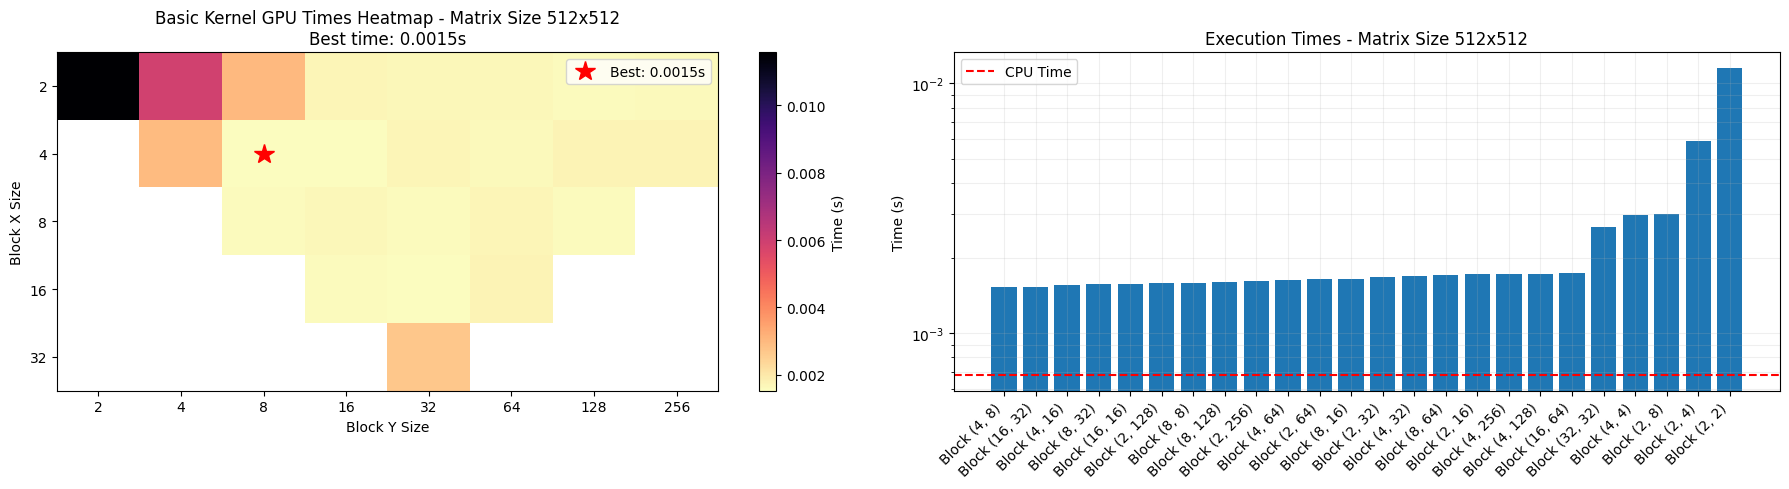

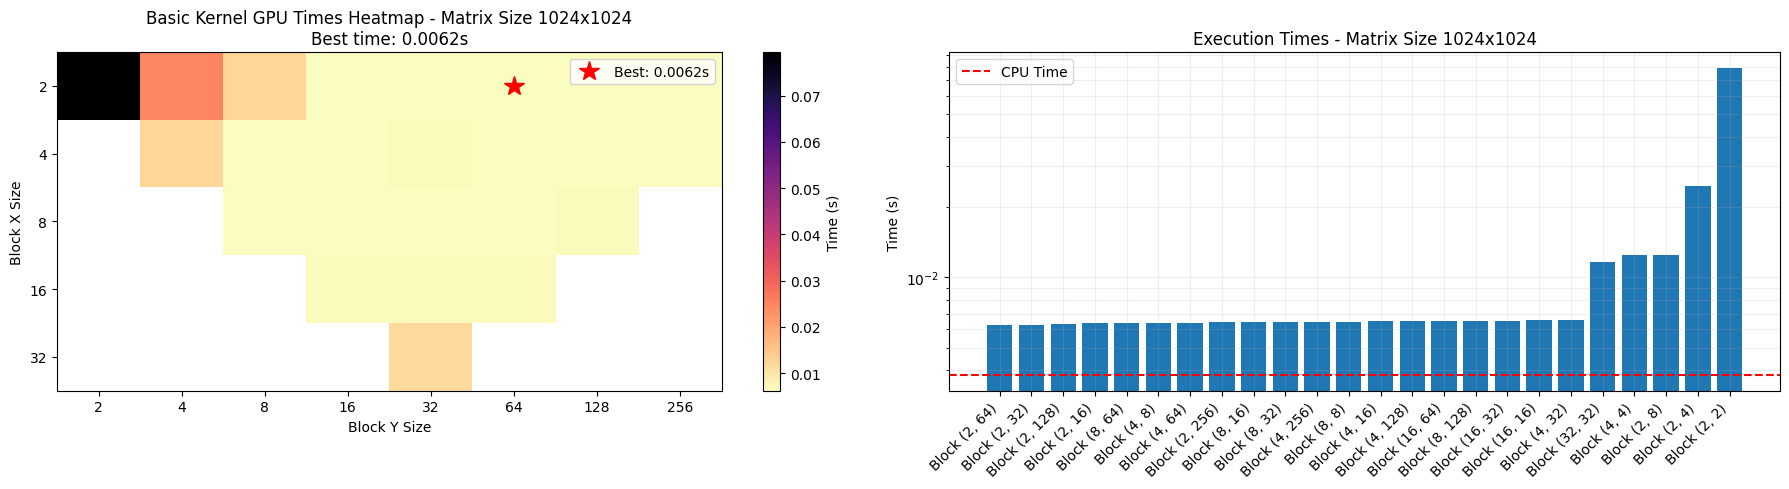

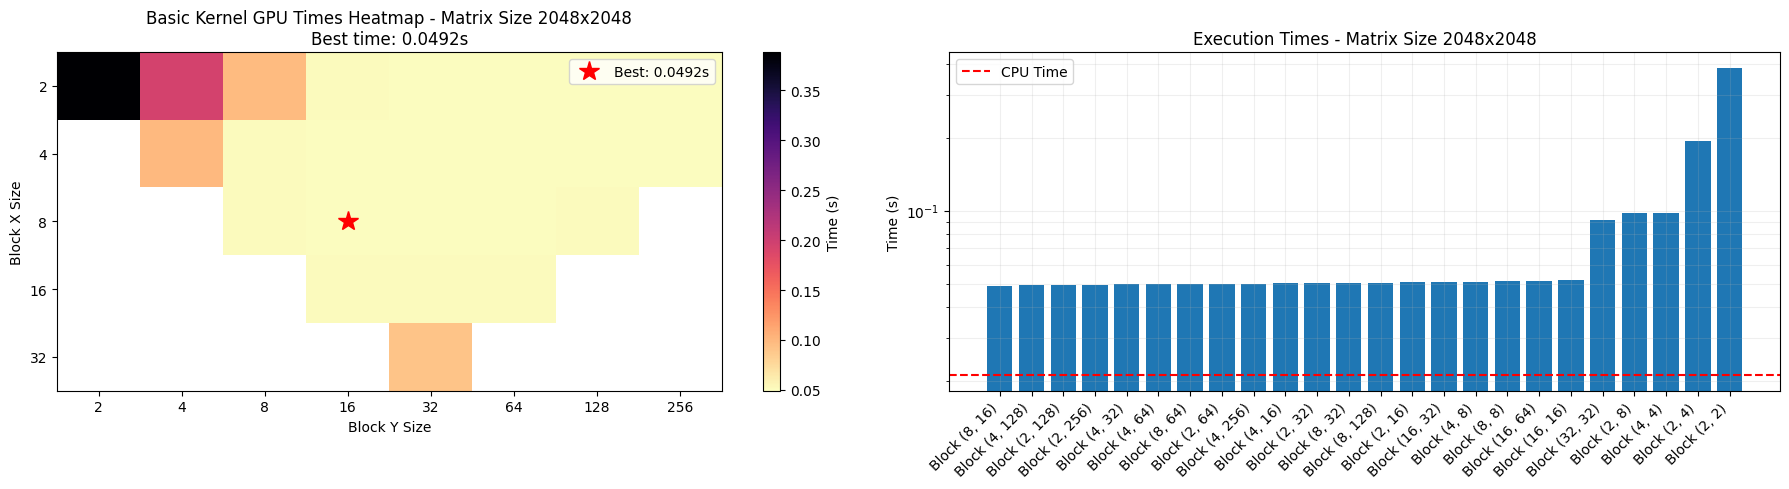


=== Best Configuration for Basic Kernel (Matrix Size 512x512) ===
Block Size: (4, 8)
GPU Time: 0.0015 seconds
Speedup over CPU: 0.45x

=== Best Configuration for Basic Kernel (Matrix Size 1024x1024) ===
Block Size: (2, 64)
GPU Time: 0.0062 seconds
Speedup over CPU: 0.61x

=== Best Configuration for Basic Kernel (Matrix Size 2048x2048) ===
Block Size: (8, 16)
GPU Time: 0.0492 seconds
Speedup over CPU: 0.43x


In [8]:
plot_results(results_basic, 'Basic Kernel')

for N in matrix_sizes:
    # Filter results for this matrix size
    results_N = [r for r in results_basic if r['matrix_size'] == N]
    best_basic = min(results_N, key=lambda x: x['gpu_time'])
    
    print(f"\n=== Best Configuration for Basic Kernel (Matrix Size {N}x{N}) ===")
    print(f"Block Size: {best_basic['block_size']}")
    print(f"GPU Time: {best_basic['gpu_time']:.4f} seconds") 
    print(f"Speedup over CPU: {best_basic['speedup']:.2f}x")

<font color='blue'>Antwort hier eingeben</font>

##### 5.2.2 Shared Memory auf der GPU
Optimiere deine Implementierung von oben indem du das shared Memory der GPU verwendest. Führe wieder mehrere Experimente mit unterschiedlicher Datengrösse durch und evaluiere den Speedup gegenüber der CPU Implementierung.

Links:
* [Best Practices Memory Optimizations](https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html#memory-optimizations)
* [Examples: Matrix Multiplikation und Shared Memory](https://numba.readthedocs.io/en/latest/cuda/examples.html)

In [9]:
### BEGIN SOLUTION
def get_kernel(threads_per_block):
    # for us tileDim is equivalent to blockSize, so 1 tile is 1 block
    tileDimX, tileDimY = threads_per_block

    @cuda.jit(fastmath=True)
    def reconstruct_svd_numba_shared(u, s, vt, out, k):
        # Early exit if k <= 0
        if k <= 0:
            return

        # global coordinates of the thread in the output matrix
        global_x, global_y = cuda.grid(2)

        # Check boundaries
        if global_y >= out.shape[1] or global_x >= out.shape[0]:
            return

        u_tile  = cuda.shared.array(shape=(tileDimX, tileDimY), dtype=float32)
        vt_tile = cuda.shared.array(shape=(tileDimX, tileDimY), dtype=float32)
        s_tile  = cuda.shared.array(shape=(tileDimX,),           dtype=float32)

        threadRow = cuda.threadIdx.x
        threadColumn = cuda.threadIdx.y

        acc = float32(0.0)

        # how many blocks can we fit into the k dimension, where k is the number of singular values
        blocks_per_grid = cuda.gridDim.x 
        for block_i in range(blocks_per_grid):
            
            # so we move horizontally across the columns of u one chunk at a time
            # basically, we start at block 0, can only move in tileDimX steps (so one tile at a time) and add the current threadColumn
            col_u = block_i * tileDimX + threadColumn
            # so essentially we take the threadRow which is threadIdx.x and the threadColumn which is threadIdx.y for the shared memory tile. 
            # we then take the GLOBAL row of the output matrix from that thread and the current tile position + threadColumn to access the correct element in the u global memory matrix
            if col_u < k:
                u_tile[threadRow, threadColumn] = u[global_x, col_u]

            # same concept we move tileDimX steps across the rows of vt
            row_vt = block_i * tileDimX + threadRow
            # okay here is the not so intuitive part. 
            # for the matrix Vt we again store the tile in the shared memory. using the same coordinates for the shared memory tile as with the u_tile matrix so vt_tile[threadRow, threadColumn].
            #
            # however, we access the global memory by looking at the current tile position * tileDimX + threadRow and the global column of the output matrix.
            # this will now create u_tile and vt_tile which share the index for the the correct value from global memory at the same coordinate within the shared matrix dimensions
            # this way u * vt would now result in a partial dot product across the tile. 
            if row_vt < k:
                vt_tile[threadRow, threadColumn] = vt[row_vt, global_y] 
                s_tile[threadRow] = s[row_vt]

            # now since the threads run async we call a syncthreads so that we know that all threads have loaded the shared memory and we essentially have a full tile in the shared memory.
            cuda.syncthreads()

            # we again g
            valid_chunk = min(tileDimX, k - block_i*tileDimX)
            for n in range(valid_chunk):
                acc += u_tile[threadRow, n] * s_tile[n] * vt_tile[n, threadColumn]

            cuda.syncthreads()

        # now we write the result to the global memory at the correct position.
        out[global_x, global_y] = acc

    return reconstruct_svd_numba_shared
### END SOLUTION

In [10]:
def benchmark_kernel(get_kernel, matrix_sizes, block_configs, svd_components):
    results = []

    for N in matrix_sizes:
        # Get precomputed components
        u = svd_components[N]['u']
        s = svd_components[N]['s'] 
        vt = svd_components[N]['vt']
        k = svd_components[N]['k']

        # Allocate device memory
        u_device = cuda.to_device(u)
        s_device = cuda.to_device(s)
        vt_device = cuda.to_device(vt)
        C_device = cuda.device_array((N, N), dtype=np.float32)

        for block_size in block_configs:
            threadsperblock = block_size
            blockspergrid_x = math.ceil(N / threadsperblock[0])
            blockspergrid_y = math.ceil(N / threadsperblock[1])
            blockspergrid = (blockspergrid_x, blockspergrid_y)
            print(f"blockspergrid: {blockspergrid}, threadsperblock: {threadsperblock}")
            
            kernel = get_kernel(threadsperblock)
            
            # Warm-up run
            kernel[blockspergrid, threadsperblock](u_device, s_device, vt_device, C_device, k)
            cuda.synchronize()
            
            start_event = cuda.event()
            stop_event = cuda.event()
            # Timed run
            start_event.record()
            kernel[blockspergrid, threadsperblock](u_device, s_device, vt_device, C_device, k)
            cuda.synchronize()
            stop_event.record()

            gpu_time_ms = cuda.event_elapsed_time(start_event, stop_event)
            gpu_time = gpu_time_ms / 1000

            # Copy result back to host
            C_gpu = C_device.copy_to_host()
            
            # check if the result is correct
            C_cpu = np.dot(np.dot(u[:N, :k], np.diag(s[:k])), vt[:k, :N])
            assert np.allclose(C_gpu, C_cpu, atol=1e-5), "Result mismatch"
            
            speedup = svd_components[N]['cpu_time'] / gpu_time
            
            results.append({
                'kernel': 'shared',
                'matrix_size': N,
                'block_size': block_size,
                'cpu_time': svd_components[N]['cpu_time'],
                'gpu_time': gpu_time,
                'speedup': speedup,
            })
            
            print(f"Block size {block_size}: GPU time = {gpu_time:.4f}s, Speedup = {speedup:.2f}x")
            
        # Clean up device memory
        del u_device, s_device, vt_device, C_device
        
    return results

results_shared = benchmark_kernel(get_kernel, matrix_sizes, block_configs, svd_components)

blockspergrid: (256, 256), threadsperblock: (2, 2)
Block size (2, 2): GPU time = 0.0132s, Speedup = 0.05x
blockspergrid: (256, 128), threadsperblock: (2, 4)
Block size (2, 4): GPU time = 0.0068s, Speedup = 0.10x
blockspergrid: (256, 64), threadsperblock: (2, 8)
Block size (2, 8): GPU time = 0.0037s, Speedup = 0.18x
blockspergrid: (256, 32), threadsperblock: (2, 16)
Block size (2, 16): GPU time = 0.0020s, Speedup = 0.34x
blockspergrid: (256, 16), threadsperblock: (2, 32)
Block size (2, 32): GPU time = 0.0016s, Speedup = 0.42x
blockspergrid: (256, 8), threadsperblock: (2, 64)
Block size (2, 64): GPU time = 0.0016s, Speedup = 0.42x
blockspergrid: (256, 4), threadsperblock: (2, 128)
Block size (2, 128): GPU time = 0.0017s, Speedup = 0.41x
blockspergrid: (256, 2), threadsperblock: (2, 256)
Block size (2, 256): GPU time = 0.0019s, Speedup = 0.37x
blockspergrid: (128, 128), threadsperblock: (4, 4)
Block size (4, 4): GPU time = 0.0023s, Speedup = 0.29x
blockspergrid: (128, 64), threadsperblock

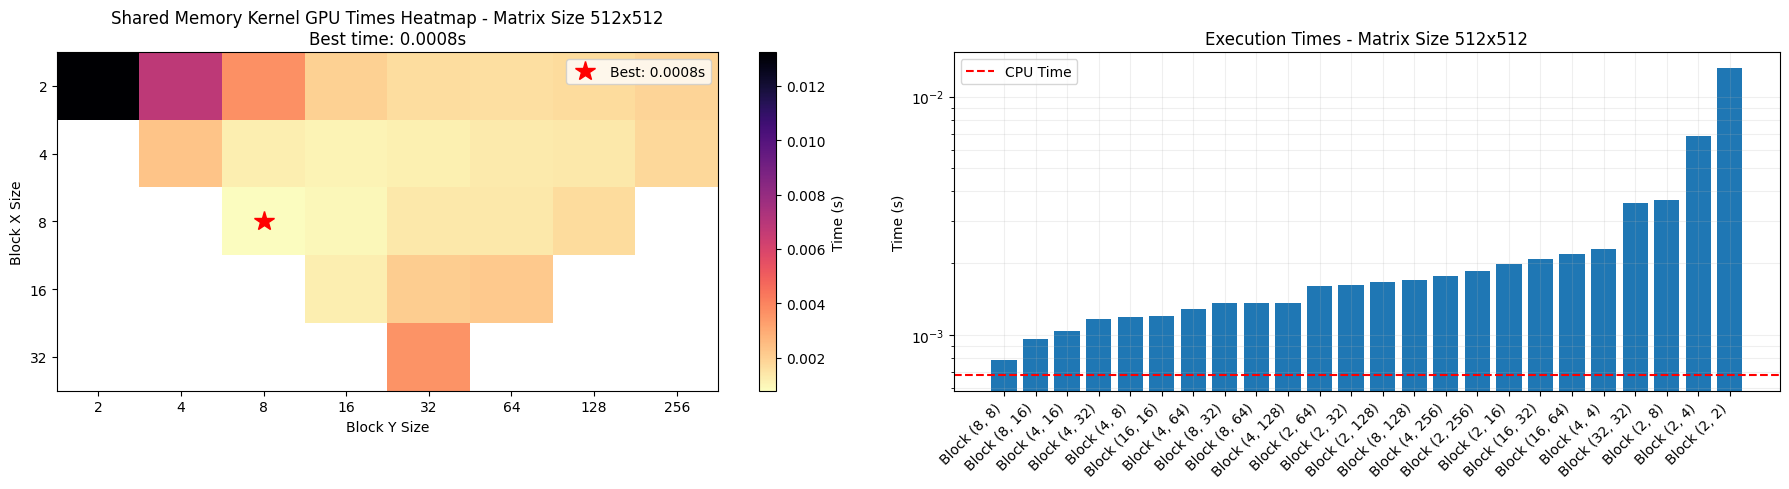

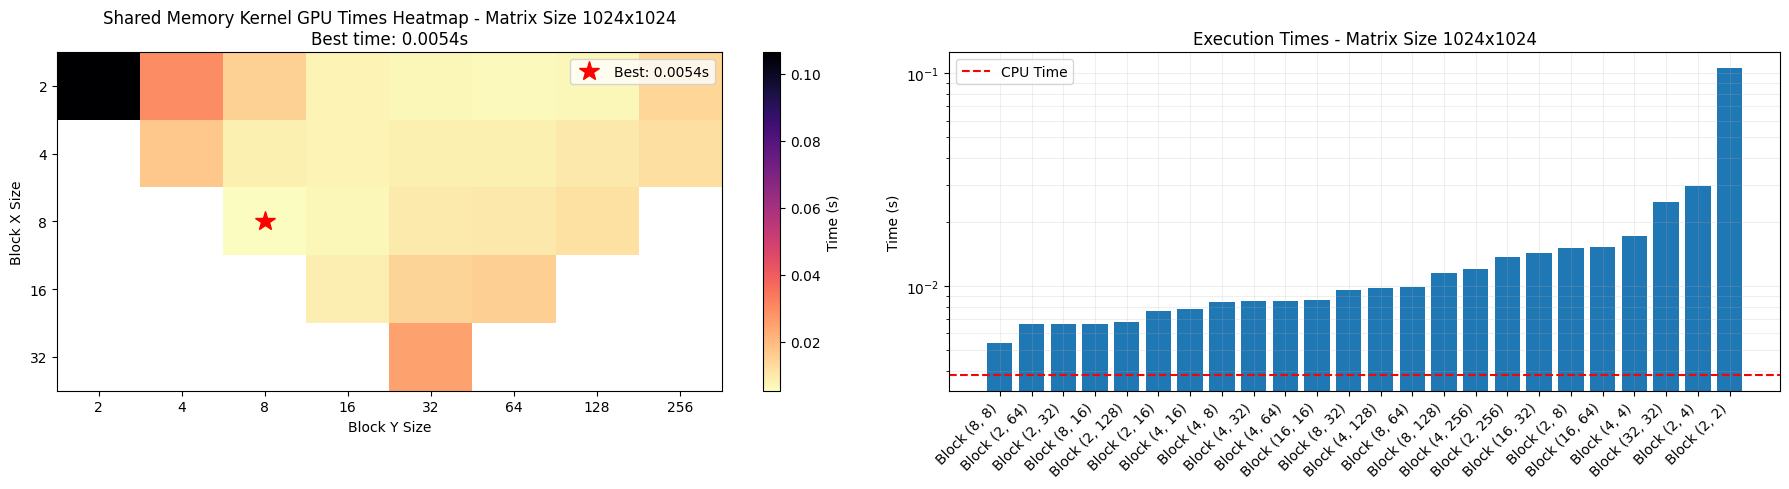

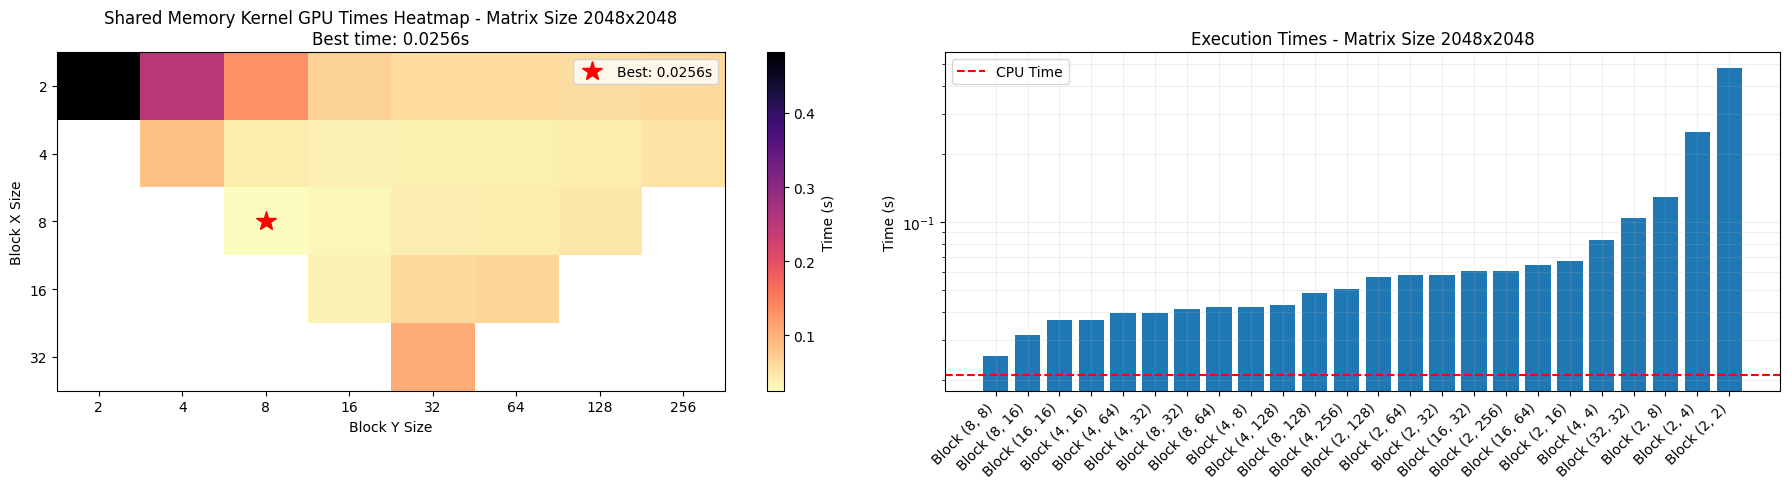

In [11]:
plot_results(results_shared, 'Shared Memory Kernel')

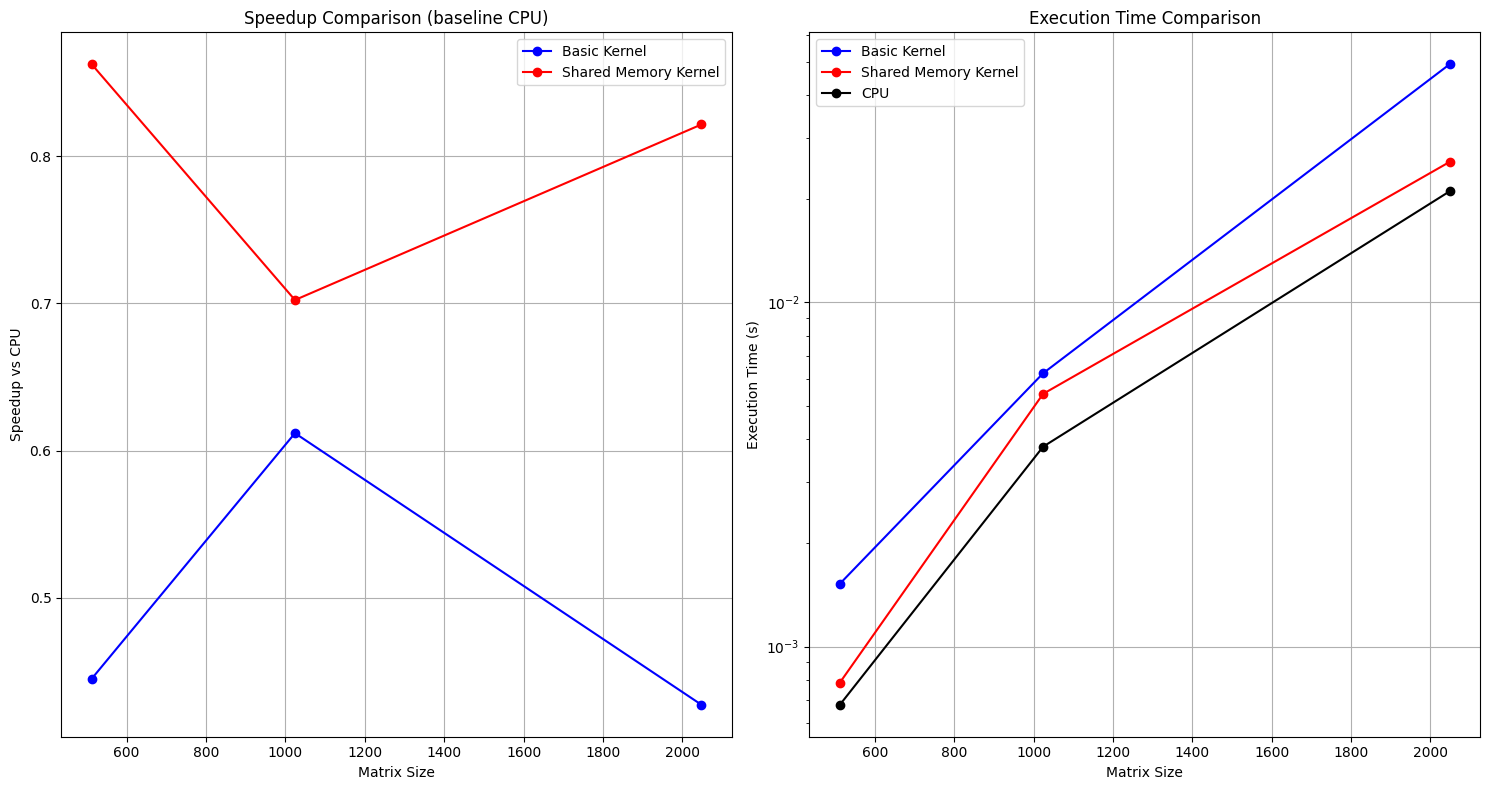


Detailed Performance Comparison:
----------------------------------------------------------------------------------------------------
Matrix Size  | Basic Kernel Time | Shared Memory Kernel Time |   Best Block Size   
----------------------------------------------------------------------------------------------------
    512      |    0.0015    |    0.0008    | (8, 8)
    1024     |    0.0062    |    0.0054    | (8, 8)
    2048     |    0.0492    |    0.0256    | (8, 8)


In [12]:
def plot_kernel_comparison(best_times_list, labels, matrix_sizes):
    """
    Plot comparison of multiple kernel implementations
    
    Args:
        best_times_list: List of dictionaries containing best times for each implementation
        labels: List of labels for each implementation
        matrix_sizes: List of matrix sizes to plot
    """
    plt.figure(figsize=(15, 8))
    
    colors = ['b', 'r', 'g', 'c', 'm', 'y']  # Add more colors if needed
    
    # Plot speedups
    plt.subplot(1, 2, 1)
    for best_times, label, color in zip(best_times_list, labels, colors):
        plt.plot(matrix_sizes, [best_times[N]['speedup'] for N in matrix_sizes], 
                f'{color}-o', label=label)
    plt.xlabel('Matrix Size')
    plt.ylabel('Speedup vs CPU')
    plt.title('Speedup Comparison (baseline CPU)')
    plt.grid(True)
    plt.legend()

    # Plot execution times
    plt.subplot(1, 2, 2)
    for best_times, label, color in zip(best_times_list, labels, colors):
        plt.plot(matrix_sizes, [best_times[N]['gpu_time'] for N in matrix_sizes], 
                f'{color}-o', label=label)
    # Add CPU time from any of the implementations (they should all have same CPU time)
    plt.plot(matrix_sizes, [best_times_list[0][N]['cpu_time'] for N in matrix_sizes], 
            'k-o', label='CPU')
    plt.xlabel('Matrix Size')
    plt.ylabel('Execution Time (s)')
    plt.title('Execution Time Comparison')
    plt.yscale('log')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print detailed comparison
    print("\nDetailed Performance Comparison:")
    print("-" * 100)
    header = f"{'Matrix Size':^12} |"
    for label in labels:
        header += f" {label+' Time':^12} |"
    header += f" {'Best Block Size':^20}"
    print(header)
    print("-" * 100)

    for N in matrix_sizes:
        row = f"{N:^12} |"
        for best_times in best_times_list:
            row += f" {best_times[N]['gpu_time']:^12.4f} |"
        # Use block size from last implementation
        row += f" {best_times[N]['block_size']}"
        print(row)

# Get best times for each matrix size
best_times_basic = {}
best_times_shared = {}

for N in matrix_sizes:
    basic_N = [r for r in results_basic if r['matrix_size'] == N]
    shared_N = [r for r in results_shared if r['matrix_size'] == N]
    best_times_basic[N] = min(basic_N, key=lambda x: x['gpu_time'])
    best_times_shared[N] = min(shared_N, key=lambda x: x['gpu_time'])

plot_kernel_comparison([best_times_basic, best_times_shared], 
                      ['Basic Kernel', 'Shared Memory Kernel'],
                      matrix_sizes)

Was sind deine Erkenntnisse bzgl. GPU-Memory-Allokation und des Daten-Transferes auf die GPU? Interpretiere deine Resultate.

<font color='blue'>Antwort hier eingeben</font>

##### 5.2.3 Bonus: Weitere Optimierungen
Optimiere deine Implementation von oben weiter. Damit du Erfolg hast, muss der Data-Reuse noch grösser sein.

In [13]:
### BEGIN SOLUTION
def get_kernel_coalesced(threads_per_block):
    # for us tileDim is equivalent to blockSize, so 1 tile is 1 block
    tileDimX, tileDimY = threads_per_block

    @cuda.jit(fastmath=True)
    def reconstruct_svd_numba_shared(u, s, vt, out, k):
        # Early exit if k <= 0
        if k <= 0:
            return

        # Global coordinates in output
        global_x = cuda.threadIdx.x + cuda.blockIdx.x * tileDimX
        global_y = cuda.threadIdx.y + cuda.blockIdx.y * tileDimY

        # Shared memory tiles
        # First dimension = tileDimY (rows), second dimension = tileDimX (cols)
        u_tile  = cuda.shared.array(shape=(tileDimY, tileDimX), dtype=float32)
        vt_tile = cuda.shared.array(shape=(tileDimY, tileDimX), dtype=float32)
        s_tile  = cuda.shared.array(shape=(tileDimX,),         dtype=float32)

        threadColumn = cuda.threadIdx.x  # up to tileDimX-1
        threadRow    = cuda.threadIdx.y  # up to tileDimY-1

        acc = float32(0.0)

        blocks_per_grid = (k + tileDimX - 1) // tileDimX

        for block_i in range(blocks_per_grid):
            # Column in U (and in s)
            col_u = block_i * tileDimX + threadColumn
            # Row in V^T
            row_vt = block_i * tileDimX + threadRow

            # Load from U and s if valid
            if col_u < k and global_y < u.shape[0]:
                u_tile[threadRow, threadColumn] = u[global_y, col_u]
                s_tile[threadColumn] = s[col_u]  # index by 'threadColumn'
            else:
                u_tile[threadRow, threadColumn] = 0.0

            # Load from V^T if valid
            if row_vt < k and global_x < vt.shape[1]:
                vt_tile[threadRow, threadColumn] = vt[row_vt, global_x]
            else:
                vt_tile[threadRow, threadColumn] = 0.0

            cuda.syncthreads()

            valid_chunk = min(tileDimX, k - block_i * tileDimX)
            for n in range(valid_chunk):
                acc += u_tile[threadRow, n] * s_tile[n] * vt_tile[n, threadColumn]

            cuda.syncthreads()

        # Write result if in-bounds
        if global_x < out.shape[1] and global_y < out.shape[0]:
            out[global_y, global_x] = acc

    return reconstruct_svd_numba_shared


    return reconstruct_svd_numba_shared
### END SOLUTION

In [14]:
results_shared_coalesced = benchmark_kernel(get_kernel_coalesced, matrix_sizes, block_configs, svd_components)


blockspergrid: (256, 256), threadsperblock: (2, 2)
Block size (2, 2): GPU time = 0.0083s, Speedup = 0.08x
blockspergrid: (256, 128), threadsperblock: (2, 4)
Block size (2, 4): GPU time = 0.0044s, Speedup = 0.16x
blockspergrid: (256, 64), threadsperblock: (2, 8)
Block size (2, 8): GPU time = 0.0027s, Speedup = 0.25x
blockspergrid: (256, 32), threadsperblock: (2, 16)
Block size (2, 16): GPU time = 0.0020s, Speedup = 0.33x
blockspergrid: (256, 16), threadsperblock: (2, 32)
Block size (2, 32): GPU time = 0.0019s, Speedup = 0.35x
blockspergrid: (256, 8), threadsperblock: (2, 64)
Block size (2, 64): GPU time = 0.0018s, Speedup = 0.38x
blockspergrid: (256, 4), threadsperblock: (2, 128)
Block size (2, 128): GPU time = 0.0017s, Speedup = 0.40x
blockspergrid: (256, 2), threadsperblock: (2, 256)
Block size (2, 256): GPU time = 0.0018s, Speedup = 0.38x
blockspergrid: (128, 128), threadsperblock: (4, 4)
Block size (4, 4): GPU time = 0.0016s, Speedup = 0.43x
blockspergrid: (128, 64), threadsperblock

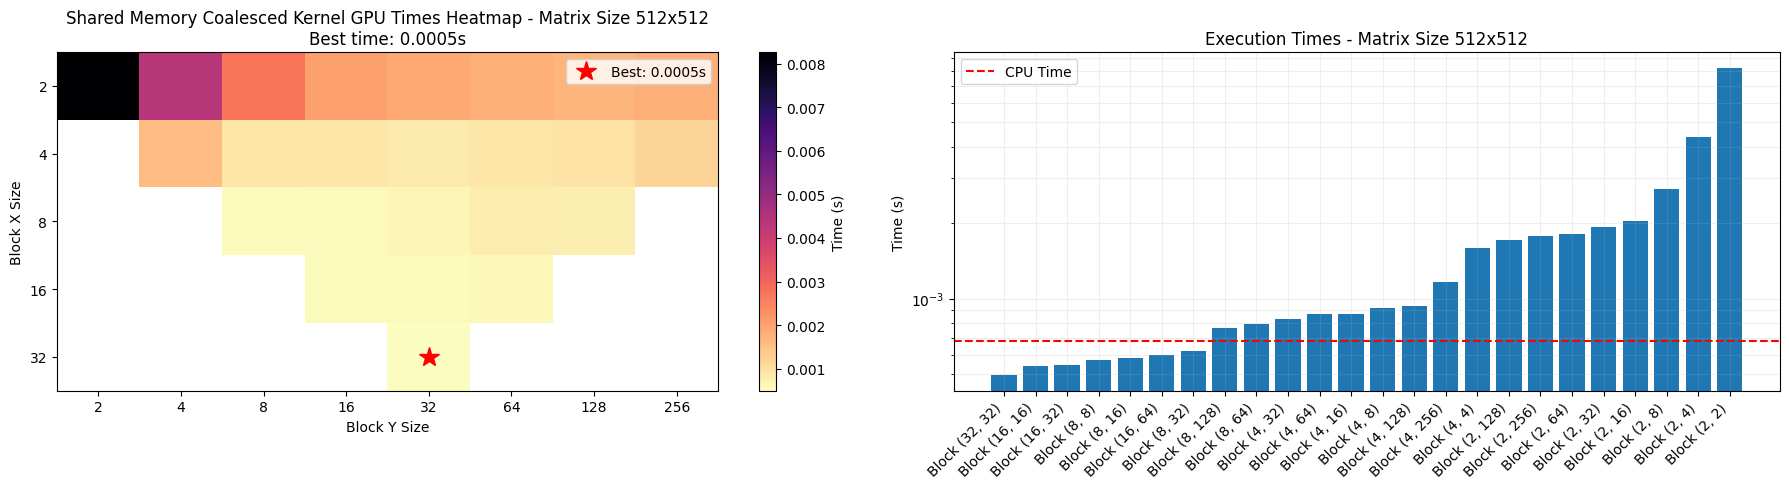

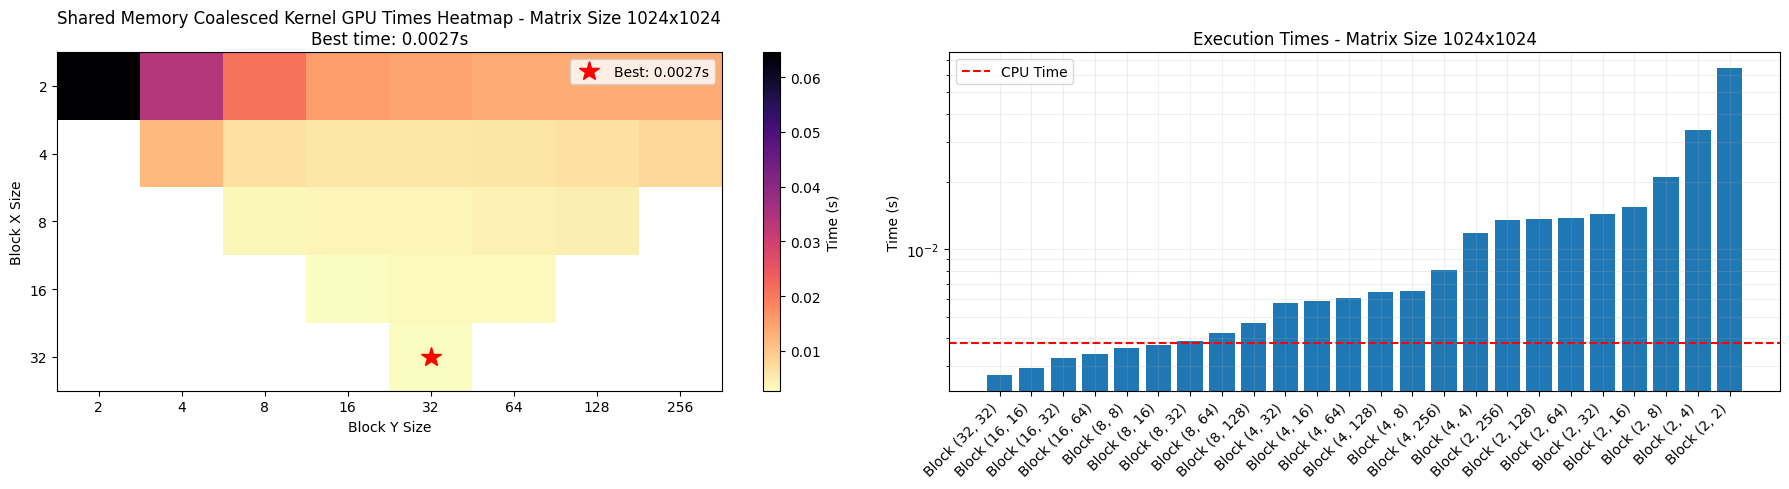

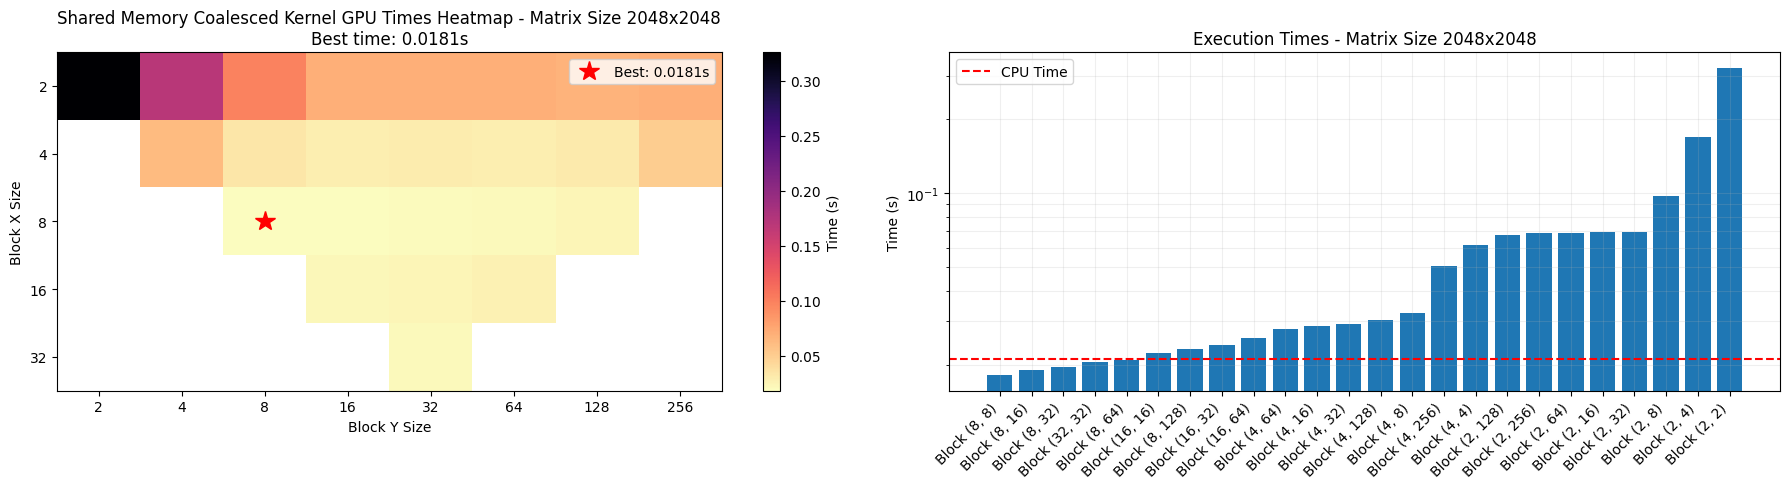

In [15]:
plot_results(results_shared_coalesced, 'Shared Memory Coalesced Kernel')

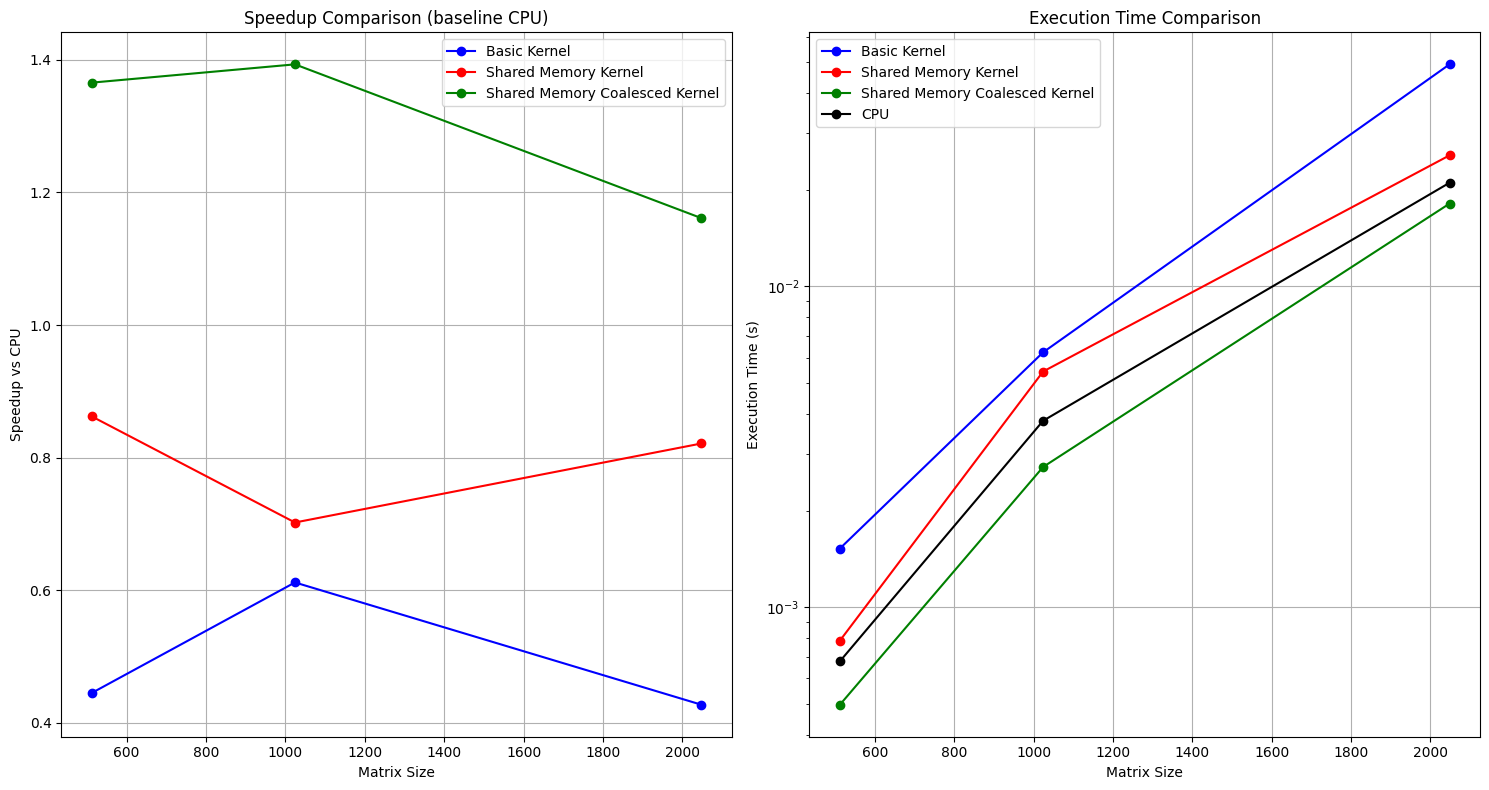


Detailed Performance Comparison:
----------------------------------------------------------------------------------------------------
Matrix Size  | Basic Kernel Time | Shared Memory Kernel Time | Shared Memory Coalesced Kernel Time |   Best Block Size   
----------------------------------------------------------------------------------------------------
    512      |    0.0015    |    0.0008    |    0.0005    | (32, 32)
    1024     |    0.0062    |    0.0054    |    0.0027    | (32, 32)
    2048     |    0.0492    |    0.0256    |    0.0181    | (8, 8)


In [16]:
best_times_shared_coalesced = {}
for N in matrix_sizes:
    shared_N = [r for r in results_shared_coalesced if r['matrix_size'] == N]
    best_times_shared_coalesced[N] = min(shared_N, key=lambda x: x['gpu_time'])

plot_kernel_comparison([best_times_basic, best_times_shared, best_times_shared_coalesced], 
                      ['Basic Kernel', 'Shared Memory Kernel', 'Shared Memory Coalesced Kernel'],
                      matrix_sizes)

In [17]:

def get_kernel_tiled(BM, BN):
    
    BK = int(BM / 2)
    TM = int(BM / 4)
    TN = int(BN / 4)

    print(f"BM: {BM}, BN: {BN}, BK: {BK}, TM: {TM}, TN: {TN}")

    @cuda.jit
    def svd_reconstruct_tiled(U, S, Vt, out, M, N, K):
        """
        estimated time spent making this work dynamically: 8 hours
        Huge thanks to https://siboehm.com/articles/22/CUDA-MMM
        """

        bx = cuda.blockIdx.x
        by = cuda.blockIdx.y
        tx = cuda.threadIdx.x
        
        # This thread is responsible for TM x TN sub-results in the final C
        # We also define how many threads per block in x-dimension:
        # if total threads in a block = (BM*BN)/(TM*TN) we can find local row/col
        # But we'll keep it simpler: each block is BM x BN results, each thread produces TM x TN sub-result
        # -> we define "threadRow" & "threadCol" in that 2D sub-block:
        threads_per_block = (BM * BN) // (TM * TN)
        # safety check or assumption:
        if threads_per_block != cuda.blockDim.x:
            return  # mismatch: user must set blockDim.x to threads_per_block

        # The row "tile" in the block for this thread:
        threadRow = tx // (BN // TN)
        threadCol = tx %  (BN // TN)

        # Output tile base index:
        row_start = by * BM
        col_start = bx * BN

        # Shared memory for chunk of U, V^T
        # U-shape: BM x BK, V^T-shape: BK x BN
        U_shared = cuda.shared.array(shape=(BM, BK), dtype=float32)
        Vt_shared = cuda.shared.array(shape=(BK, BN), dtype=float32)

        # each thread accumulates TM x TN partial results
        result = cuda.local.array(shape=(TM, TN), dtype=float32)
        for r in range(TM):
            for c in range(TN):
                result[r, c] = 0.0


        # for each block tile in the K dimension
        for k_tile in range(0, K, BK):
            # each thread loads some portion of the BM x BK chunk
            load_x = tx
            # we'll stride along BM direction in increments of blockDim.x so downward 
            while load_x < BM:
                # go through the BK dimension (across the columns) ---> 
                for kk in range(BK):
                    real_k = k_tile + kk
                    if real_k < K and (row_start + load_x) < M:
                        U_shared[load_x, kk] = U[row_start + load_x, real_k]
                    else:
                        U_shared[load_x, kk] = 0.0
                load_x += threads_per_block

            # load the tile of V^T into Bs
            load_y = tx
            # go through the BN dimension (across the columns) of V^T so to the right
            while load_y < BN:
                # go through the BK dimension (across the rows) of V^T so to the bottom
                for kk in range(BK):
                    real_k = k_tile + kk
                    if real_k < K and (col_start + load_y) < N:
                        # we allocate the S tile here as well to save storage
                        Vt_shared[kk, load_y] = Vt[real_k, col_start + load_y] * S[real_k]
                    else:
                        Vt_shared[kk, load_y] = 0.0
                load_y += threads_per_block

            cuda.syncthreads()

            # compute partial sums for TM x TN sub-block in registers
            #  dotIdx is always across bk so inner dim
            for dotIdx in range(BK):
                # first row wise 
                for i in range(TM):
                    # row in As
                    rowA = threadRow * TM + i
                    aVal = U_shared[rowA, dotIdx]
                    # then col wise
                    for j in range(TN):
                        # col in Bs
                        colB = threadCol * TN + j
                        # calculate the partial sum for all the rows of that col in Bs within a thread
                        result[i, j] += aVal * Vt_shared[dotIdx, colB]

            cuda.syncthreads()

        # store results to global memory
        for i in range(TM):
            out_row = row_start + (threadRow * TM) + i
            if out_row < M:
                for j in range(TN):
                    out_col = col_start + (threadCol * TN) + j
                    if out_col < N:
                        out[out_row, out_col] = result[i, j]
    return svd_reconstruct_tiled


In [18]:

results_reuse = []



for N in matrix_sizes:
    # Get precomputed components
    u = svd_components[N]['u']
    s = svd_components[N]['s'] 
    vt = svd_components[N]['vt']
    k = svd_components[N]['k']

    # Allocate device memory
    u_device = cuda.to_device(u)
    s_device = cuda.to_device(s)
    vt_device = cuda.to_device(vt)
    C_device = cuda.device_array((N, N), dtype=np.float32)

    for block_size in block_configs:
        # skip configs that are below 4x4
        if block_size[0] < 4 or block_size[1] < 4:
           continue
           
        # we don't have to technically spilit as our matrix is square
        M, _ = u.shape
        _, N = vt.shape
        # Tile sizes: BM=16, BN=16 => we want grid = ceil(M/16, N/16) blocks
        BM = int(block_size[0])
        BN = int(block_size[1])
        blocks_x = math.ceil(N / BN)
        blocks_y = math.ceil(M / BM)
        
        threads_per_block = (BM * BN) // (BM / 4 * BN / 4)   # = (16*16)/(4*4) = 16

        

        kernel = get_kernel_tiled(BM, BN)
        grid_dim = (blocks_x, blocks_y)
        block_dim = (int(threads_per_block),)
        kernel[grid_dim, block_dim](u_device, s_device, vt_device, C_device, M, N, k)
        cuda.synchronize()
        
        
        start_event = cuda.event()
        stop_event = cuda.event()
        # Timed run
        start_event.record()
        kernel[grid_dim, block_dim](u_device, s_device, vt_device, C_device, M, N, k)
        cuda.synchronize()
        stop_event.record()

        gpu_time_ms = cuda.event_elapsed_time(start_event, stop_event)
        gpu_time = gpu_time_ms / 1000

        # Copy result back to host
        C_gpu = C_device.copy_to_host()
        
        # check if the result is correct
        C_cpu = np.dot(np.dot(u[:N, :k], np.diag(s[:k])), vt[:k, :N])
        assert np.allclose(C_gpu, C_cpu, atol=1e-1), "Result mismatch"
        
        speedup = svd_components[N]['cpu_time'] / gpu_time
        
        results_reuse.append({
            'kernel': 'shared',
            'matrix_size': N,
            'block_size': block_size,
            'cpu_time': svd_components[N]['cpu_time'],
            'gpu_time': gpu_time,
            'speedup': speedup,
        })
        
        print(f"Block size {block_size}: GPU time = {gpu_time:.4f}s, Speedup = {speedup:.2f}x")



BM: 4, BN: 4, BK: 2, TM: 1, TN: 1
Block size (4, 4): GPU time = 0.0031s, Speedup = 0.22x
BM: 4, BN: 8, BK: 2, TM: 1, TN: 2
Block size (4, 8): GPU time = 0.0017s, Speedup = 0.40x
BM: 4, BN: 16, BK: 2, TM: 1, TN: 4
Block size (4, 16): GPU time = 0.0010s, Speedup = 0.68x
BM: 4, BN: 32, BK: 2, TM: 1, TN: 8
Block size (4, 32): GPU time = 0.0007s, Speedup = 1.00x
BM: 4, BN: 64, BK: 2, TM: 1, TN: 16
Block size (4, 64): GPU time = 0.0008s, Speedup = 0.86x
BM: 4, BN: 128, BK: 2, TM: 1, TN: 32
Block size (4, 128): GPU time = 0.0011s, Speedup = 0.62x
BM: 4, BN: 256, BK: 2, TM: 1, TN: 64
Block size (4, 256): GPU time = 0.0014s, Speedup = 0.48x
BM: 8, BN: 8, BK: 4, TM: 2, TN: 2
Block size (8, 8): GPU time = 0.0010s, Speedup = 0.71x
BM: 8, BN: 16, BK: 4, TM: 2, TN: 4
Block size (8, 16): GPU time = 0.0006s, Speedup = 1.18x
BM: 8, BN: 32, BK: 4, TM: 2, TN: 8
Block size (8, 32): GPU time = 0.0005s, Speedup = 1.37x
BM: 8, BN: 64, BK: 4, TM: 2, TN: 16
Block size (8, 64): GPU time = 0.0006s, Speedup = 1.2

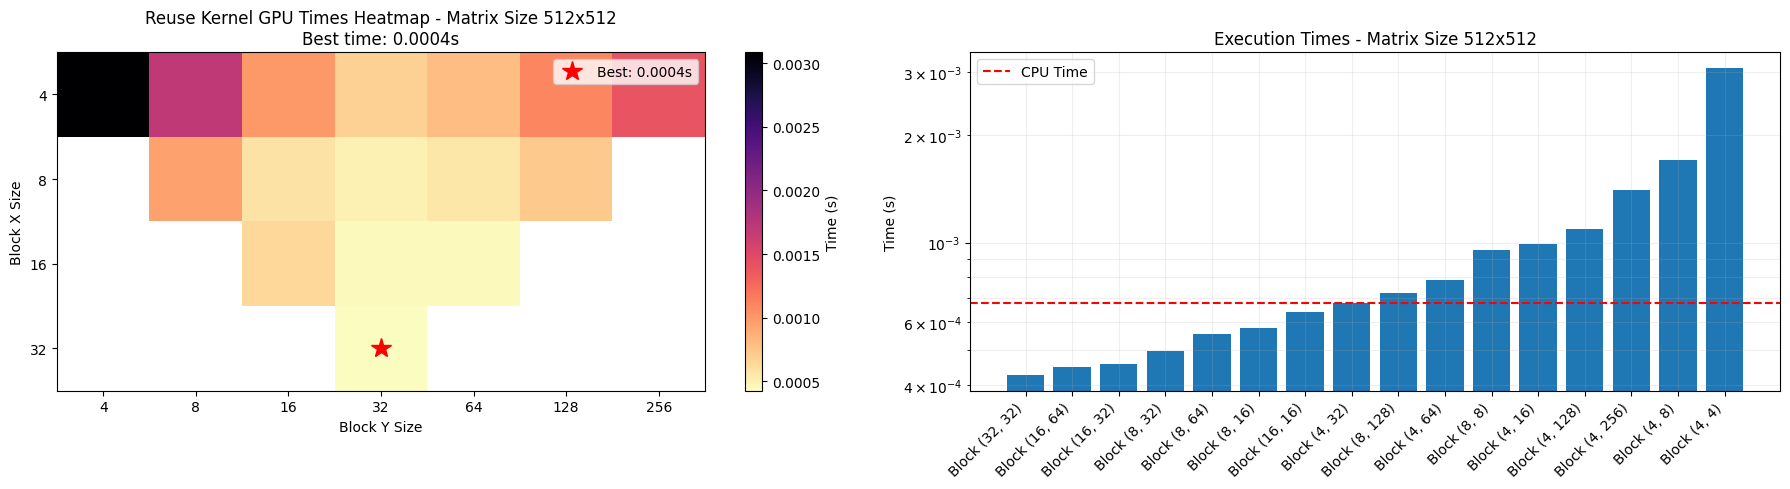

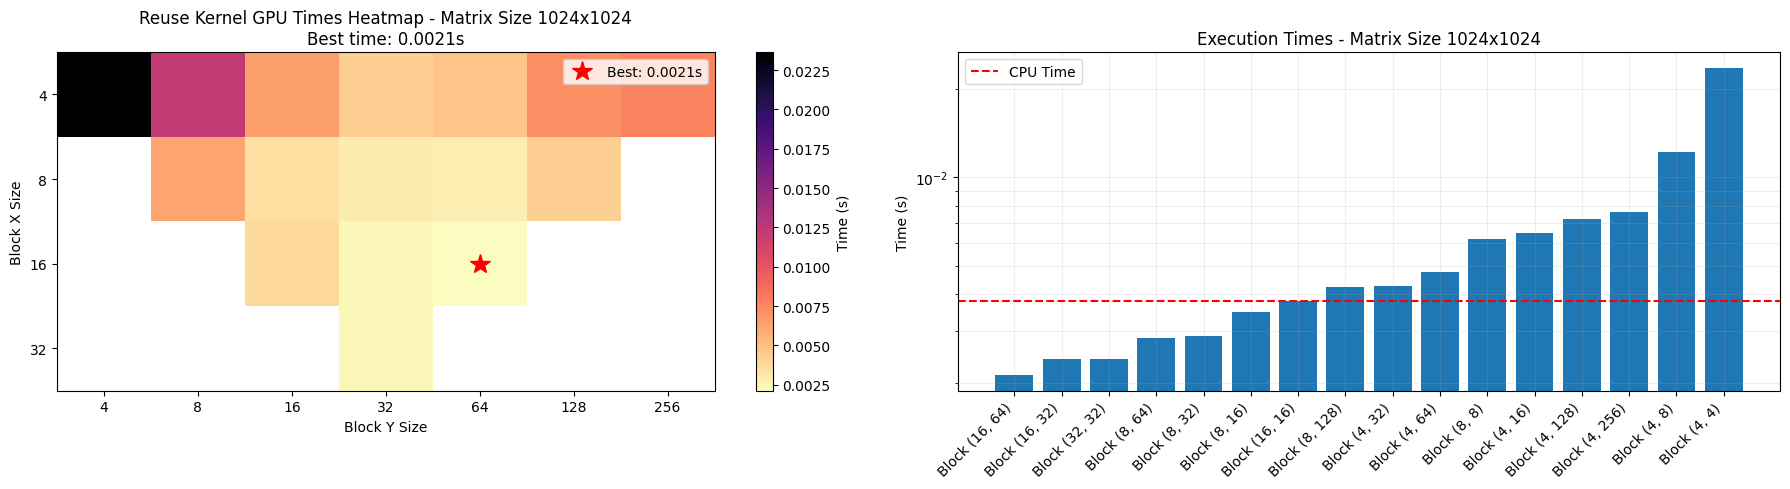

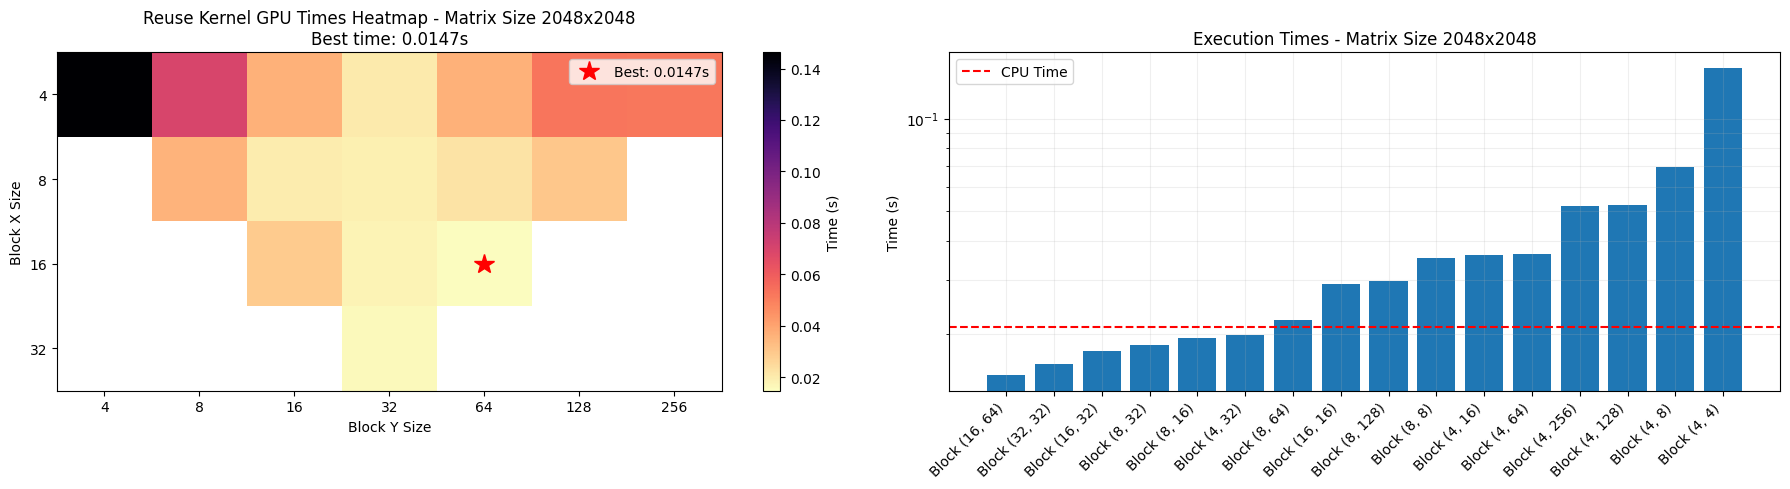

In [19]:
plot_results(results_reuse, 'Reuse Kernel')

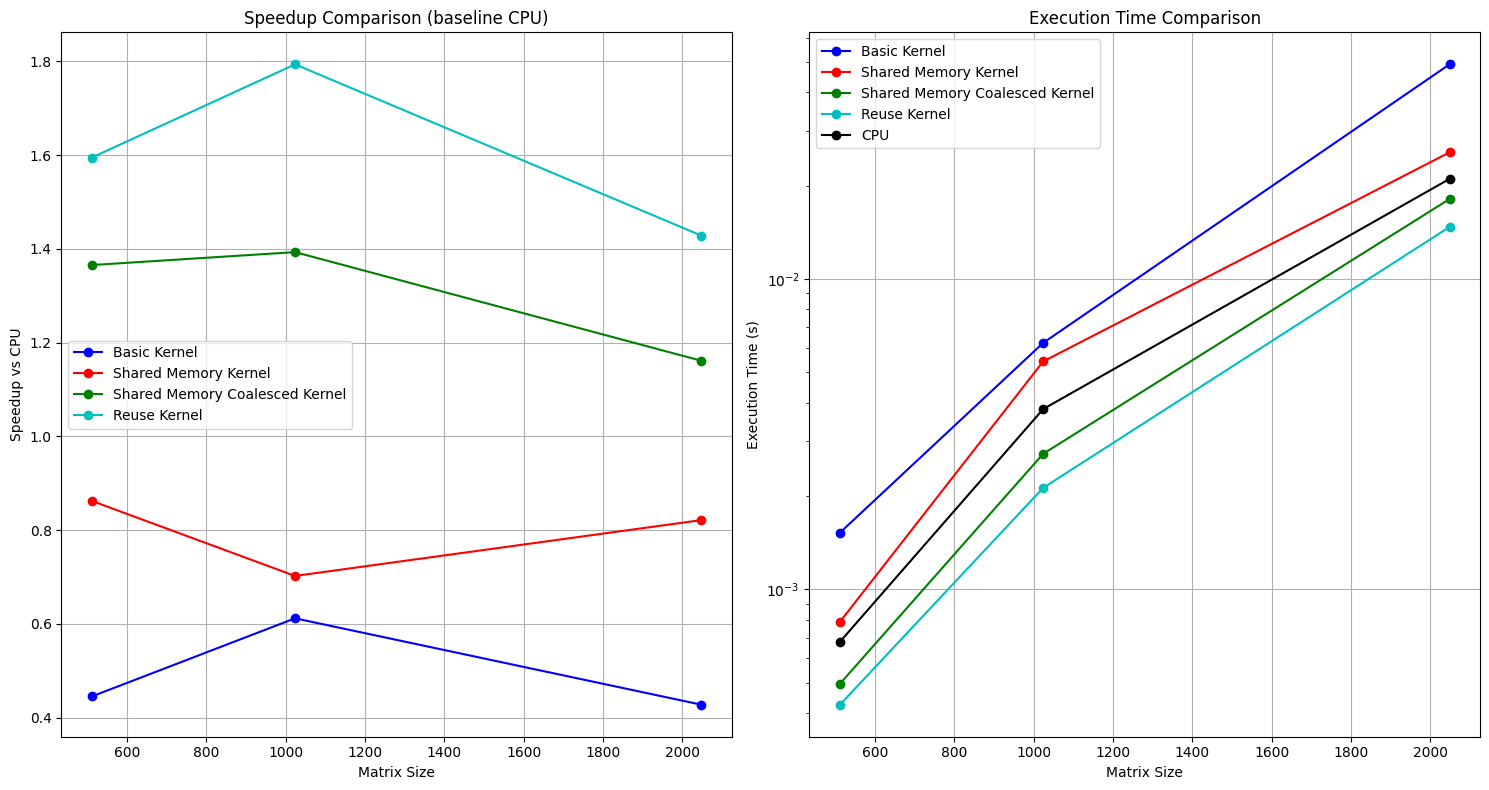


Detailed Performance Comparison:
----------------------------------------------------------------------------------------------------
Matrix Size  | Basic Kernel Time | Shared Memory Kernel Time | Shared Memory Coalesced Kernel Time | Reuse Kernel Time |   Best Block Size   
----------------------------------------------------------------------------------------------------
    512      |    0.0015    |    0.0008    |    0.0005    |    0.0004    | (32, 32)
    1024     |    0.0062    |    0.0054    |    0.0027    |    0.0021    | (16, 64)
    2048     |    0.0492    |    0.0256    |    0.0181    |    0.0147    | (16, 64)


In [20]:
best_times_reuse = {}
for N in matrix_sizes:
    shared_N = [r for r in results_reuse if r['matrix_size'] == N]
    best_times_reuse[N] = min(shared_N, key=lambda x: x['gpu_time'])

plot_kernel_comparison([best_times_basic, best_times_shared, best_times_shared_coalesced, best_times_reuse], 
                      ['Basic Kernel', 'Shared Memory Kernel', 'Shared Memory Coalesced Kernel', 'Reuse Kernel'],
                      matrix_sizes)

#### 5.3 NVIDIA Profiler

Benutze einen Performance Profiler von NVIDIA, um Bottlenecks in deinem Code zu identifizieren bzw. unterschiedliche Implementierungen (Blocks, Memory etc.) zu vergleichen. 

* Siehe Beispiel example_profiling_CUDA.ipynb
* [Nsight](https://developer.nvidia.com/nsight-visual-studio-edition) für das Profiling des Codes und die Inspektion der Ergebnisse (neuste Variante)
* [nvprof](https://docs.nvidia.com/cuda/profiler-users-guide/index.html#nvprof-overview)
* [Nvidia Visual Profiler](https://docs.nvidia.com/cuda/profiler-users-guide/index.html#visual)

> Du kannst NVIDIA Nsights Systems und den Nvidia Visual Profiler auf deinem PC installieren und die Leistungsergebnisse aus einer Remote-Instanz visualisieren, auch wenn du keine GPU an/in deinem PC hast. Dafür kannst du die ``*.qdrep`` Datei generieren und danach lokal laden.


Dokumentiere deine Analyse ggf. mit 1-2 Visualisierungen und beschreibe, welche Bottlenecks du gefunden bzw. entschärft hast.

<font color='blue'>Antwort hier eingeben inkl. Bild.</font>

##### Optimization

I started off with the optimized kernel from 5.2.3 and then used the ncu profiler to find the bottlenecks. Even though it is the fastest kernel so far, I want to push it below 10ms on a 2048x2048 matrix.

NCU Profile: optimized_profile_original.ncu-rep



In [25]:

def get_kernel_tiled_v1(BM, BN):
    
    BK = int(BM / 2)
    ### The 4.00 theoretical warps per scheduler this kernel can issue according to its occupancy are below the hardware maximum of 8. This kernel's theoretical occupancy (50.0%) is limited by the number of blocks that can fit on the SM. This kernel's theoretical occupancy (50.0%) is limited by the number of required registers.
    # we will decrease the matrix per thread, therefore leading to more threads
    TM = int(BM / 8)
    TN = int(BN / 8)

    print(f"BM: {BM}, BN: {BN}, BK: {BK}, TM: {TM}, TN: {TN}")

    @cuda.jit
    def svd_reconstruct_tiled(U, S, Vt, out, M, N, K):
        """
        estimated time spent making this work dynamically: 8 hours
        Huge thanks to https://siboehm.com/articles/22/CUDA-MMM
        """

        bx = cuda.blockIdx.x
        by = cuda.blockIdx.y
        tx = cuda.threadIdx.x
        
        # This thread is responsible for TM x TN sub-results in the final C
        # We also define how many threads per block in x-dimension:
        # if total threads in a block = (BM*BN)/(TM*TN) we can find local row/col
        # But we'll keep it simpler: each block is BM x BN results, each thread produces TM x TN sub-result
        # -> we define "threadRow" & "threadCol" in that 2D sub-block:
        threads_per_block = (BM * BN) // (TM * TN)
        # safety check or assumption:
        if threads_per_block != cuda.blockDim.x:
            return  # mismatch: user must set blockDim.x to threads_per_block

        # The row "tile" in the block for this thread:
        threadRow = tx // (BN // TN)
        threadCol = tx %  (BN // TN)

        # Output tile base index:
        row_start = by * BM
        col_start = bx * BN

        # Shared memory for chunk of U, V^T
        # U-shape: BM x BK, V^T-shape: BK x BN
        U_shared = cuda.shared.array(shape=(BM, BK), dtype=float32)
        Vt_shared = cuda.shared.array(shape=(BK, BN), dtype=float32)

        # each thread accumulates TM x TN partial results
        result = cuda.local.array(shape=(TM, TN), dtype=float32)
        for r in range(TM):
            for c in range(TN):
                result[r, c] = 0.0


        # for each block tile in the K dimension
        for k_tile in range(0, K, BK):
            # each thread loads some portion of the BM x BK chunk
            load_x = tx
            # we'll stride along BM direction in increments of blockDim.x so downward 
            while load_x < BM:
                # go through the BK dimension (across the columns) ---> 
                for kk in range(BK):
                    real_k = k_tile + kk
                    if real_k < K and (row_start + load_x) < M:
                        U_shared[load_x, kk] = U[row_start + load_x, real_k]
                    else:
                        U_shared[load_x, kk] = 0.0
                load_x += threads_per_block

            # load the tile of V^T into Bs
            load_y = tx
            # go through the BN dimension (across the columns) of V^T so to the right
            while load_y < BN:
                # go through the BK dimension (across the rows) of V^T so to the bottom
                for kk in range(BK):
                    real_k = k_tile + kk
                    if real_k < K and (col_start + load_y) < N:
                        # we allocate the S tile here as well to save storage
                        Vt_shared[kk, load_y] = Vt[real_k, col_start + load_y] * S[real_k]
                    else:
                        Vt_shared[kk, load_y] = 0.0
                load_y += threads_per_block

            cuda.syncthreads()

            # compute partial sums for TM x TN sub-block in registers
            #  dotIdx is always across bk so inner dim
            for dotIdx in range(BK):
                # first row wise 
                for i in range(TM):
                    # row in As
                    rowA = threadRow * TM + i
                    aVal = U_shared[rowA, dotIdx]
                    # then col wise
                    for j in range(TN):
                        # col in Bs
                        colB = threadCol * TN + j
                        # calculate the partial sum for all the rows of that col in Bs within a thread
                        result[i, j] += aVal * Vt_shared[dotIdx, colB]

            cuda.syncthreads()

        # store results to global memory
        for i in range(TM):
            out_row = row_start + (threadRow * TM) + i
            if out_row < M:
                for j in range(TN):
                    out_col = col_start + (threadCol * TN) + j
                    if out_col < N:
                        out[out_row, out_col] = result[i, j]
    return svd_reconstruct_tiled

In [26]:

results_tile_v1 = []

for N in matrix_sizes:
    # Get precomputed components
    u = svd_components[N]['u']
    s = svd_components[N]['s'] 
    vt = svd_components[N]['vt']
    k = svd_components[N]['k']

    # Allocate device memory
    u_device = cuda.to_device(u)
    s_device = cuda.to_device(s)
    vt_device = cuda.to_device(vt)
    C_device = cuda.device_array((N, N), dtype=np.float32)

    for block_size in block_configs:
        # skip configs that are below 4x4
        if block_size[0] < 8 or block_size[1] < 8:
           continue
           
        # we don't have to technically spilit as our matrix is square
        M, _ = u.shape
        _, N = vt.shape
        # Tile sizes: BM=16, BN=16 => we want grid = ceil(M/16, N/16) blocks
        BM = int(block_size[0])
        BN = int(block_size[1])
        blocks_x = math.ceil(N / BN)
        blocks_y = math.ceil(M / BM)
        
        threads_per_block = (BM * BN) // (BM / 8 * BN / 8)   # = (16*16)/(4*4) = 16


        kernel = get_kernel_tiled_v1(BM, BN)
        grid_dim = (blocks_x, blocks_y)
        block_dim = (int(threads_per_block),)
        kernel[grid_dim, block_dim](u_device, s_device, vt_device, C_device, M, N, k)
        cuda.synchronize()
        
        
        start_event = cuda.event()
        stop_event = cuda.event()
        # Timed run
        start_event.record()
        kernel[grid_dim, block_dim](u_device, s_device, vt_device, C_device, M, N, k)
        cuda.synchronize()
        stop_event.record()

        gpu_time_ms = cuda.event_elapsed_time(start_event, stop_event)
        gpu_time = gpu_time_ms / 1000

        # Copy result back to host
        C_gpu = C_device.copy_to_host()
        
        # check if the result is correct
        C_cpu = np.dot(np.dot(u[:N, :k], np.diag(s[:k])), vt[:k, :N])
        assert np.allclose(C_gpu, C_cpu, atol=1e-1), "Result mismatch"
        
        speedup = svd_components[N]['cpu_time'] / gpu_time
        
        results_tile_v1.append({
            'kernel': 'shared',
            'matrix_size': N,
            'block_size': block_size,
            'cpu_time': svd_components[N]['cpu_time'],
            'gpu_time': gpu_time,
            'speedup': speedup,
        })
        
        print(f"Block size {block_size}: GPU time = {gpu_time:.4f}s, Speedup = {speedup:.2f}x")




BM: 8, BN: 8, BK: 4, TM: 1, TN: 1
Block size (8, 8): GPU time = 0.0009s, Speedup = 0.66x
BM: 8, BN: 16, BK: 4, TM: 1, TN: 2
Block size (8, 16): GPU time = 0.0005s, Speedup = 1.14x
BM: 8, BN: 32, BK: 4, TM: 1, TN: 4
Block size (8, 32): GPU time = 0.0004s, Speedup = 1.55x
BM: 8, BN: 64, BK: 4, TM: 1, TN: 8
Block size (8, 64): GPU time = 0.0004s, Speedup = 1.54x
BM: 8, BN: 128, BK: 4, TM: 1, TN: 16
Block size (8, 128): GPU time = 0.0006s, Speedup = 1.06x
BM: 16, BN: 16, BK: 8, TM: 2, TN: 2
Block size (16, 16): GPU time = 0.0005s, Speedup = 1.17x
BM: 16, BN: 32, BK: 8, TM: 2, TN: 4
Block size (16, 32): GPU time = 0.0004s, Speedup = 1.64x
BM: 16, BN: 64, BK: 8, TM: 2, TN: 8
Block size (16, 64): GPU time = 0.0003s, Speedup = 1.82x
BM: 32, BN: 32, BK: 16, TM: 4, TN: 4
Block size (32, 32): GPU time = 0.0004s, Speedup = 1.61x
BM: 8, BN: 8, BK: 4, TM: 1, TN: 1
Block size (8, 8): GPU time = 0.0063s, Speedup = 0.50x
BM: 8, BN: 16, BK: 4, TM: 1, TN: 2
Block size (8, 16): GPU time = 0.0035s, Speedup

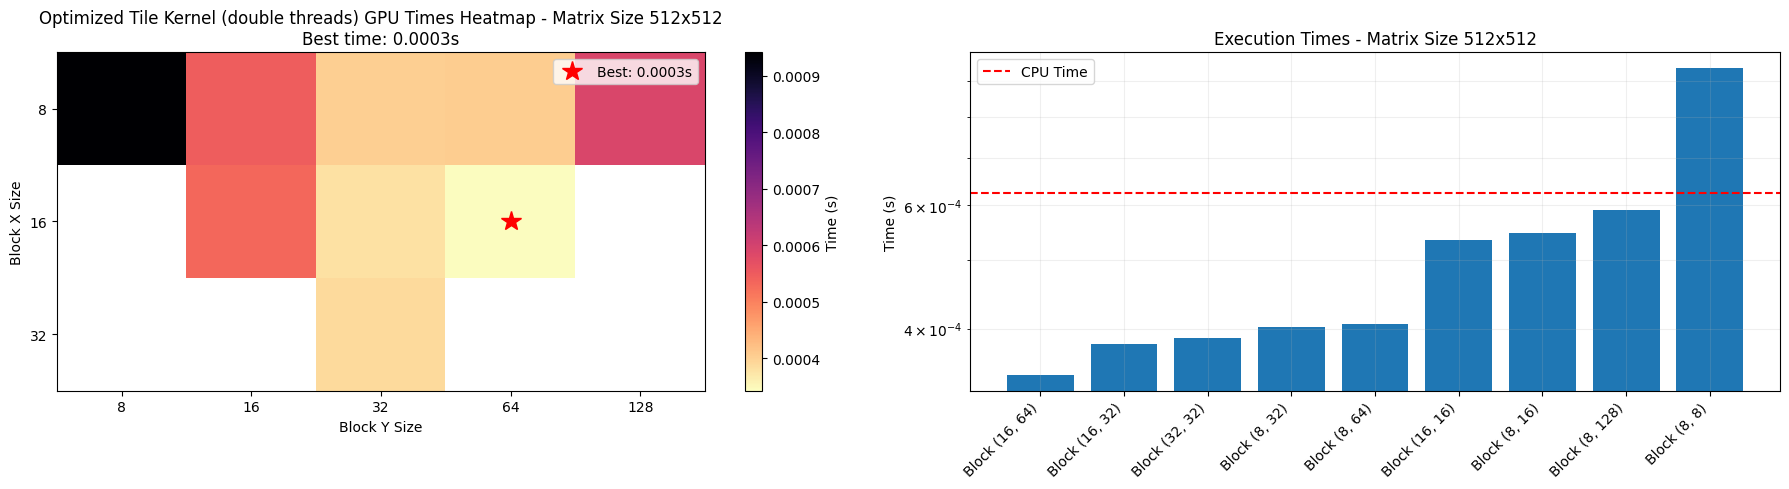

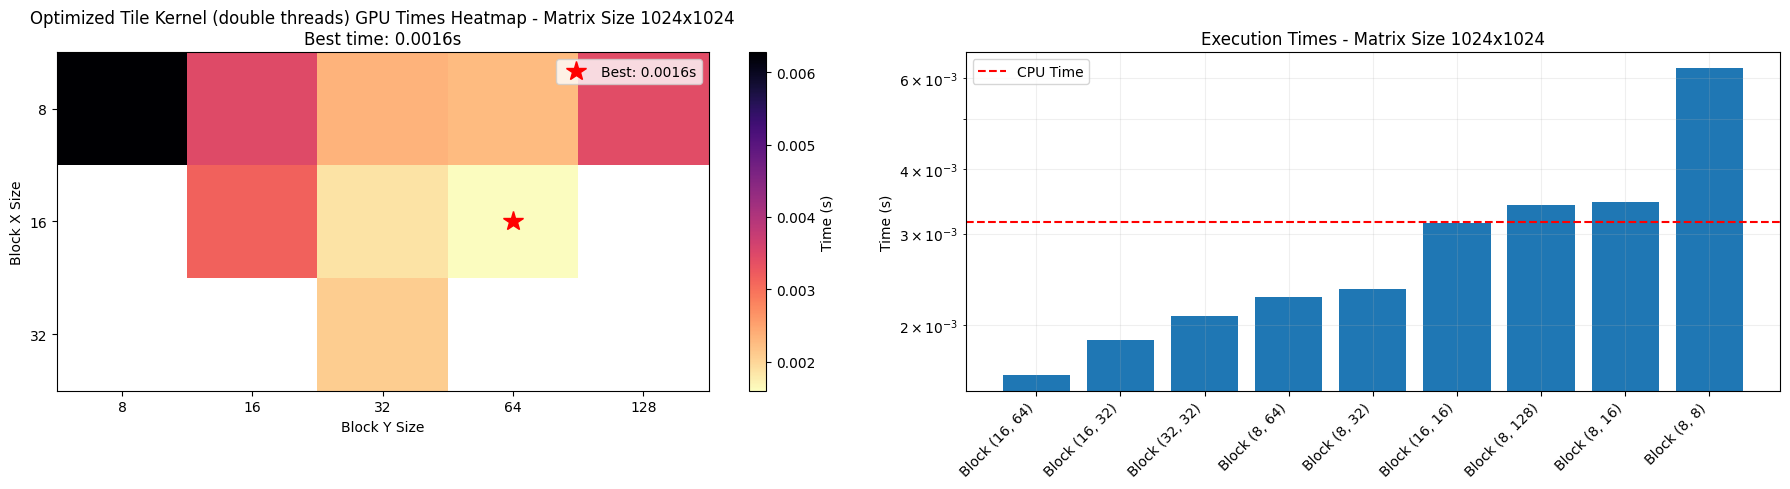

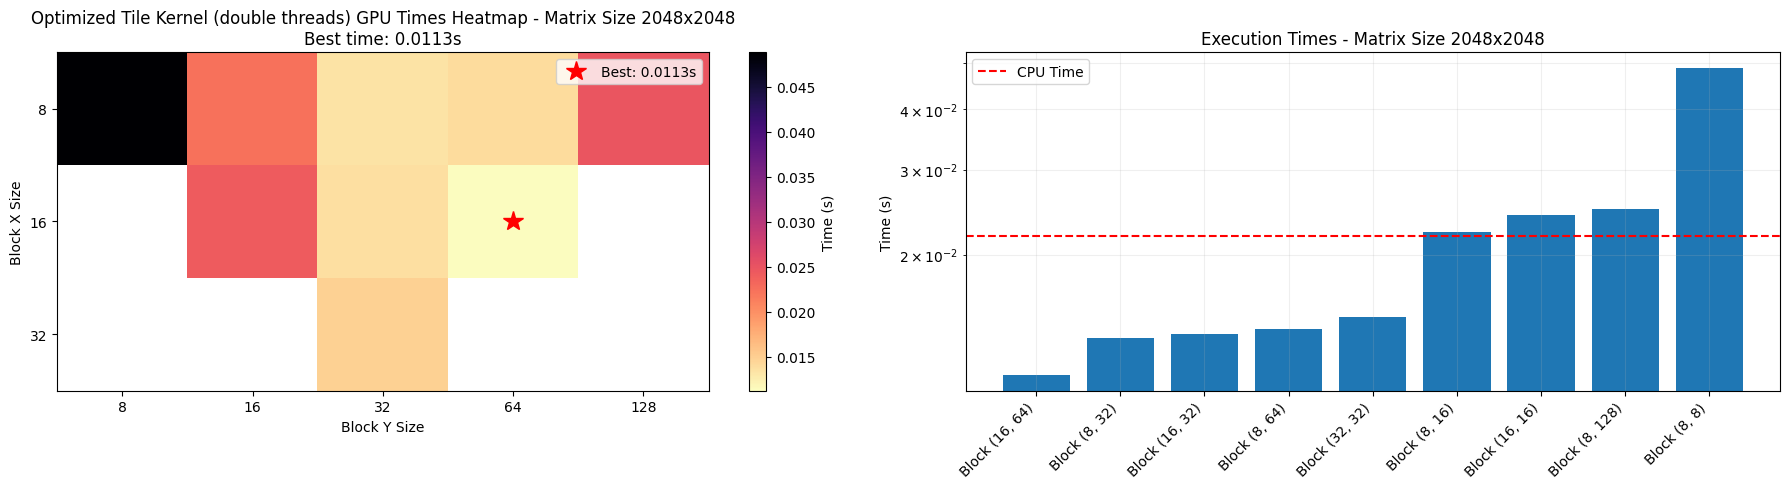

In [27]:
plot_results(results_tile_v1, 'Optimized Tile Kernel (double threads)')

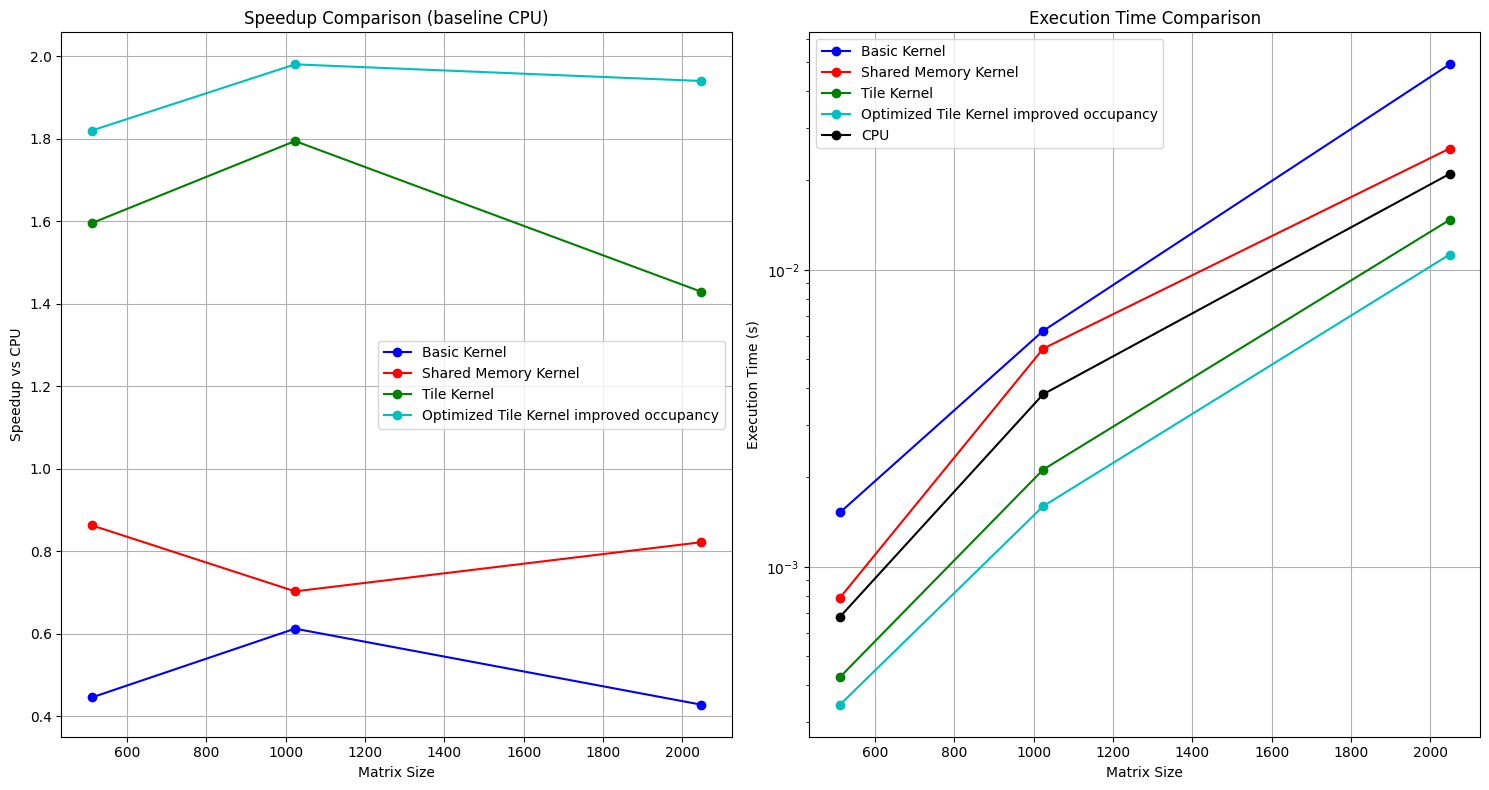


Detailed Performance Comparison:
----------------------------------------------------------------------------------------------------
Matrix Size  | Basic Kernel Time | Shared Memory Kernel Time | Tile Kernel Time | Optimized Tile Kernel improved occupancy Time |   Best Block Size   
----------------------------------------------------------------------------------------------------
    512      |    0.0015    |    0.0008    |    0.0004    |    0.0003    | (16, 64)
    1024     |    0.0062    |    0.0054    |    0.0021    |    0.0016    | (16, 64)
    2048     |    0.0492    |    0.0256    |    0.0147    |    0.0113    | (16, 64)


In [29]:
best_times_tile_v1 = {}
for N in matrix_sizes:
    optimized_tile_v1 = [r for r in results_tile_v1 if r['matrix_size'] == N]
    best_times_tile_v1[N] = min(optimized_tile_v1, key=lambda x: x['gpu_time'])

plot_kernel_comparison([best_times_basic, best_times_shared, best_times_reuse, best_times_tile_v1], 
                      ['Basic Kernel', 'Shared Memory Kernel', 'Tile Kernel', 'Optimized Tile Kernel improved occupancy'],
                      matrix_sizes) 

In [30]:

def get_kernel_tiled_padded(BM, BN):
    BK = int(BM / 2)
    TM = int(BM / 8)
    TN = int(BN / 8)
    PAD_U_COL = BK + 1
    PAD_V_COL = BN + 1

    print(f"BM: {BM}, BN: {BN}, BK: {BK}, TM: {TM}, TN: {TN} (with padding)")

    @cuda.jit
    def svd_reconstruct_tiled_padded(U, S, Vt, out, M, N, K):
        bx = cuda.blockIdx.x
        by = cuda.blockIdx.y
        tx = cuda.threadIdx.x

        threads_per_block = (BM * BN) // (TM * TN)
        if threads_per_block != cuda.blockDim.x:
            return  # mismatch

        threadRow = tx // (BN // TN)
        threadCol = tx %  (BN // TN)

        row_start = by * BM
        col_start = bx * BN

        # Notice we add 1 to BK dimension => shape=(BM, BK+1)
        U_shared = cuda.shared.array(shape=(BM, PAD_U_COL), dtype=float32)
        Vt_shared = cuda.shared.array(shape=(BK, PAD_V_COL), dtype=float32)
        
        result = cuda.local.array(shape=(TM, TN), dtype=float32)
        for r in range(TM):
            for c in range(TN):
                result[r, c] = 0.0

        for k_tile in range(0, K, BK):
            load_x = tx
            while load_x < BM:
                for kk in range(BK):
                    real_k = k_tile + kk
                    if real_k < K and (row_start + load_x) < M:
                        U_shared[load_x, kk] = U[row_start + load_x, real_k]
                    else:
                        U_shared[load_x, kk] = 0.0
                load_x += threads_per_block

            load_y = tx
            while load_y < BN:
                for kk in range(BK):
                    real_k = k_tile + kk
                    if real_k < K and (col_start + load_y) < N:
                        # multiply in S right here
                        Vt_shared[kk, load_y] = Vt[real_k, col_start + load_y] * S[real_k]
                    else:
                        Vt_shared[kk, load_y] = 0.0
                load_y += threads_per_block

            cuda.syncthreads()

            # compute partial sums
            for dotIdx in range(BK):
                for i in range(TM):
                    rowA = threadRow * TM + i
                    aVal = U_shared[rowA, dotIdx]
                    for j in range(TN):
                        colB = threadCol * TN + j
                        result[i, j] += aVal * Vt_shared[dotIdx, colB]

            cuda.syncthreads()

        # store
        for i in range(TM):
            out_row = row_start + (threadRow * TM) + i
            if out_row < M:
                for j in range(TN):
                    out_col = col_start + (threadCol * TN) + j
                    if out_col < N:
                        out[out_row, out_col] = result[i, j]

    return svd_reconstruct_tiled_padded


In [31]:

results_tile_v2 = []

for N in matrix_sizes:
    # Get precomputed components
    u = svd_components[N]['u']
    s = svd_components[N]['s'] 
    vt = svd_components[N]['vt']
    k = svd_components[N]['k']

    # Allocate device memory
    u_device = cuda.to_device(u)
    s_device = cuda.to_device(s)
    vt_device = cuda.to_device(vt)
    C_device = cuda.device_array((N, N), dtype=np.float32)

    for block_size in block_configs:
        # skip configs that are below 4x4
        if block_size[0] < 8 or block_size[1] < 8:
           continue
           
        # we don't have to technically spilit as our matrix is square
        M, _ = u.shape
        _, N = vt.shape
        # Tile sizes: BM=16, BN=16 => we want grid = ceil(M/16, N/16) blocks
        BM = int(block_size[0])
        BN = int(block_size[1])
        blocks_x = math.ceil(N / BN)
        blocks_y = math.ceil(M / BM)
        
        threads_per_block = (BM * BN) // (BM / 8 * BN / 8)   # = (16*16)/(4*4) = 16


        kernel = get_kernel_tiled_padded(BM, BN)
        grid_dim = (blocks_x, blocks_y)
        block_dim = (int(threads_per_block),)
        kernel[grid_dim, block_dim](u_device, s_device, vt_device, C_device, M, N, k)
        cuda.synchronize()
        
        
        start_event = cuda.event()
        stop_event = cuda.event()
        # Timed run
        start_event.record()
        kernel[grid_dim, block_dim](u_device, s_device, vt_device, C_device, M, N, k)
        cuda.synchronize()
        stop_event.record()

        gpu_time_ms = cuda.event_elapsed_time(start_event, stop_event)
        gpu_time = gpu_time_ms / 1000

        # Copy result back to host
        C_gpu = C_device.copy_to_host()
        
        # check if the result is correct
        C_cpu = np.dot(np.dot(u[:N, :k], np.diag(s[:k])), vt[:k, :N])
        assert np.allclose(C_gpu, C_cpu, atol=1e-1), "Result mismatch"
        
        speedup = svd_components[N]['cpu_time'] / gpu_time
        
        results_tile_v2.append({
            'kernel': 'shared',
            'matrix_size': N,
            'block_size': block_size,
            'cpu_time': svd_components[N]['cpu_time'],
            'gpu_time': gpu_time,
            'speedup': speedup,
        })
        
        print(f"Block size {block_size}: GPU time = {gpu_time:.4f}s, Speedup = {speedup:.2f}x")




BM: 8, BN: 8, BK: 4, TM: 1, TN: 1 (with padding)
Block size (8, 8): GPU time = 0.0009s, Speedup = 0.69x
BM: 8, BN: 16, BK: 4, TM: 1, TN: 2 (with padding)
Block size (8, 16): GPU time = 0.0006s, Speedup = 1.13x
BM: 8, BN: 32, BK: 4, TM: 1, TN: 4 (with padding)
Block size (8, 32): GPU time = 0.0004s, Speedup = 1.57x
BM: 8, BN: 64, BK: 4, TM: 1, TN: 8 (with padding)
Block size (8, 64): GPU time = 0.0004s, Speedup = 1.48x
BM: 8, BN: 128, BK: 4, TM: 1, TN: 16 (with padding)
Block size (8, 128): GPU time = 0.0006s, Speedup = 1.05x
BM: 16, BN: 16, BK: 8, TM: 2, TN: 2 (with padding)
Block size (16, 16): GPU time = 0.0005s, Speedup = 1.34x
BM: 16, BN: 32, BK: 8, TM: 2, TN: 4 (with padding)
Block size (16, 32): GPU time = 0.0003s, Speedup = 1.85x
BM: 16, BN: 64, BK: 8, TM: 2, TN: 8 (with padding)
Block size (16, 64): GPU time = 0.0003s, Speedup = 1.92x
BM: 32, BN: 32, BK: 16, TM: 4, TN: 4 (with padding)
Block size (32, 32): GPU time = 0.0003s, Speedup = 1.99x
BM: 8, BN: 8, BK: 4, TM: 1, TN: 1 (w

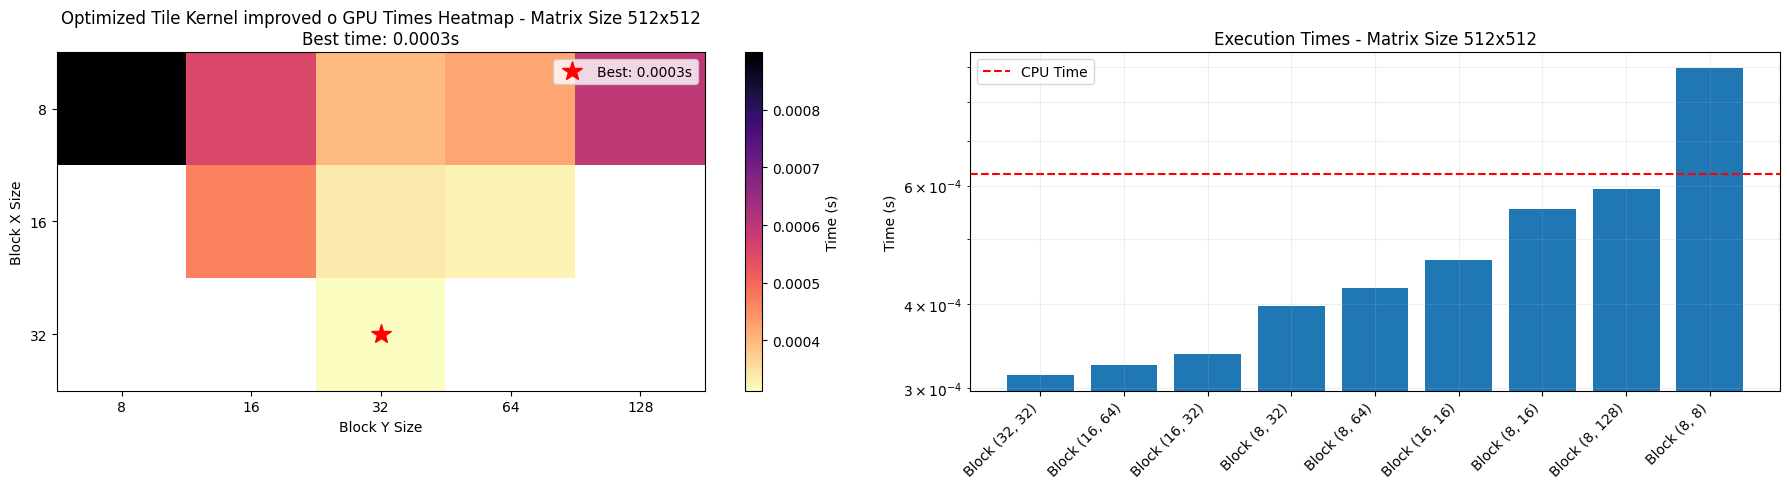

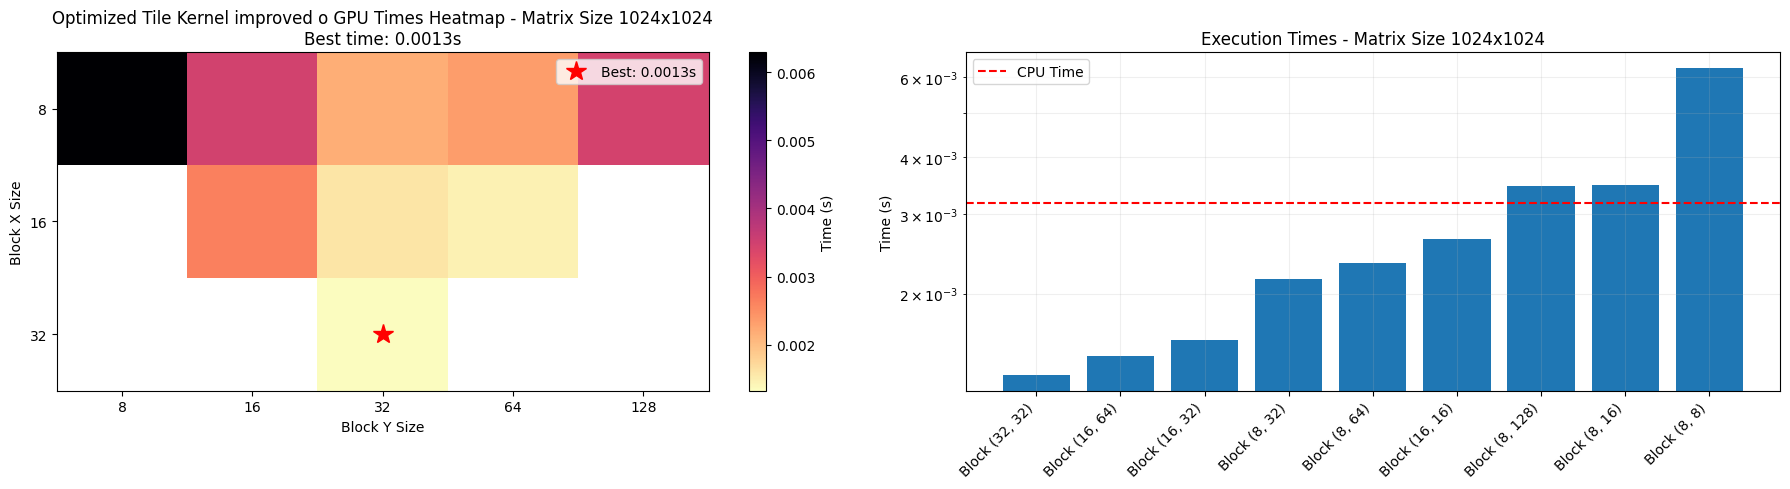

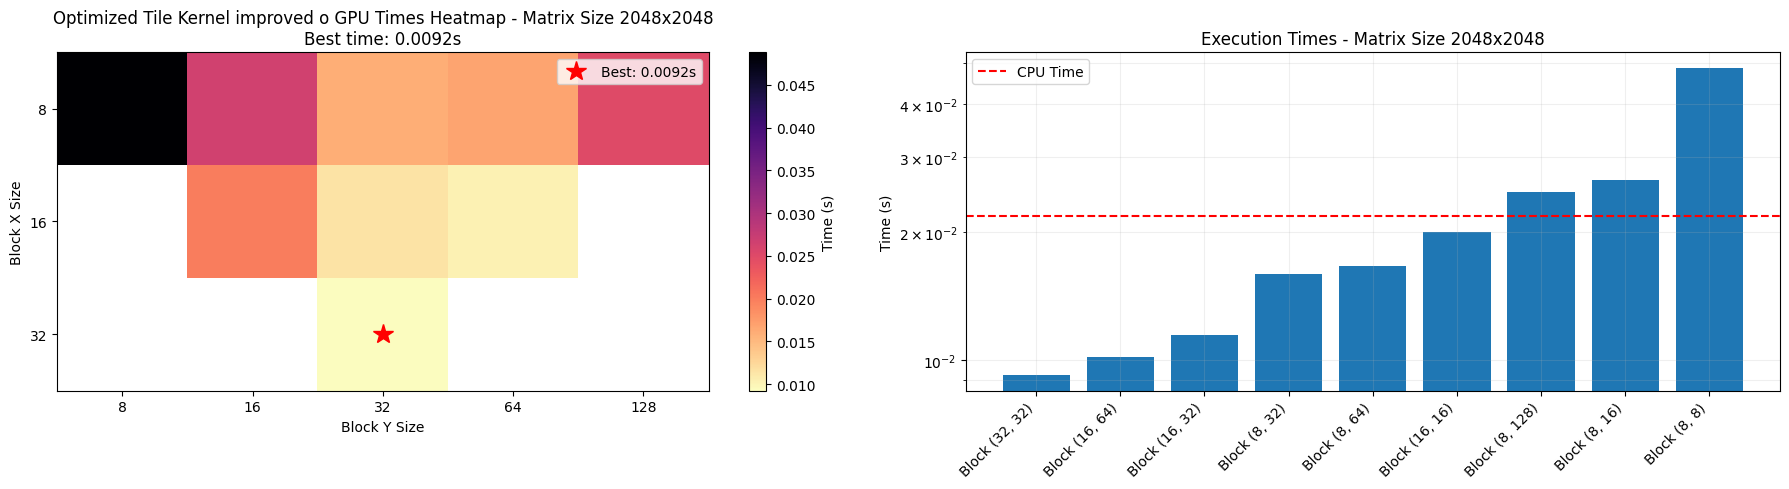

In [33]:
plot_results(results_tile_v2, 'Optimized Tile Kernel improved o')

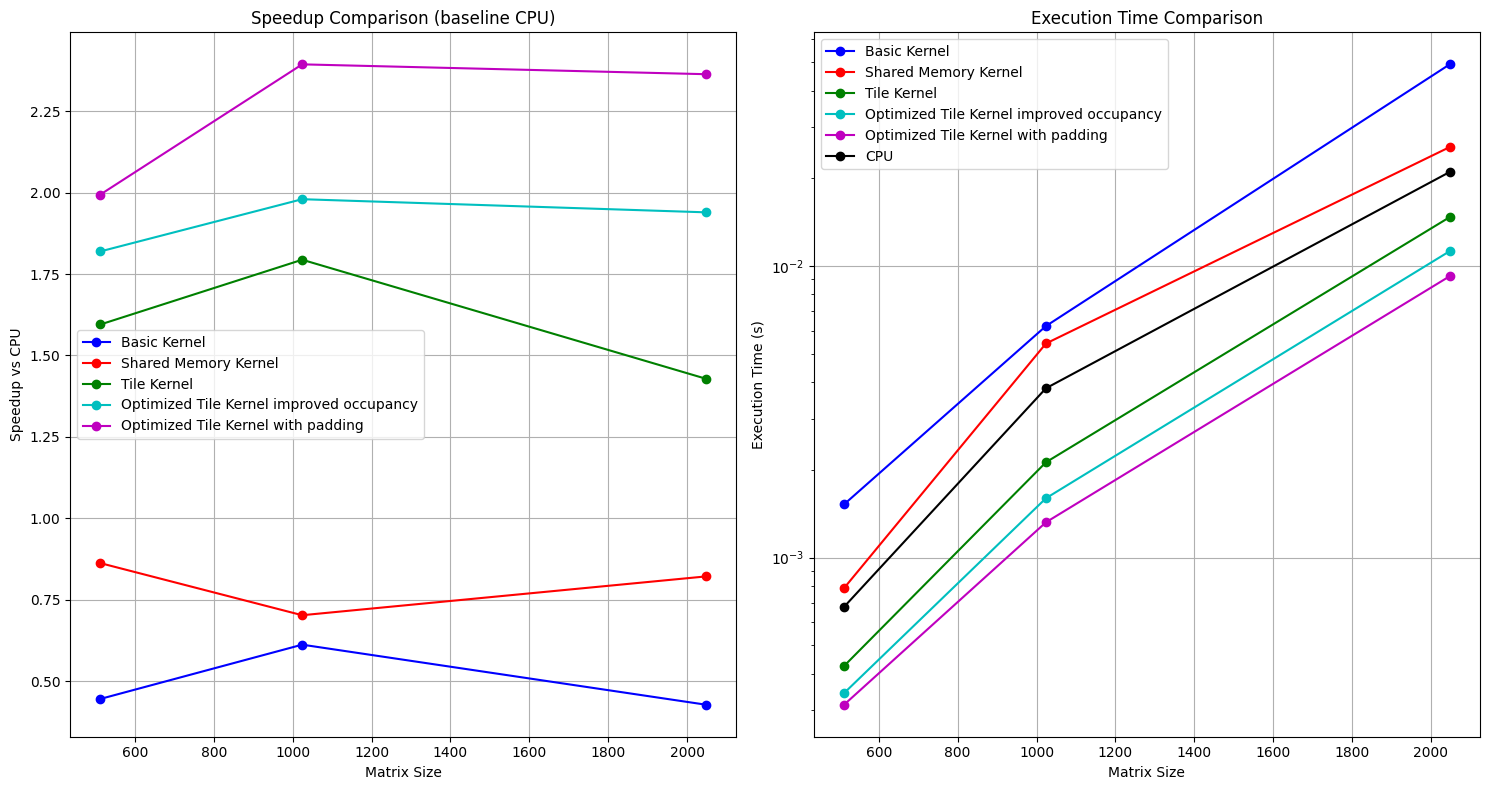


Detailed Performance Comparison:
----------------------------------------------------------------------------------------------------
Matrix Size  | Basic Kernel Time | Shared Memory Kernel Time | Tile Kernel Time | Optimized Tile Kernel improved occupancy Time | Optimized Tile Kernel with padding Time |   Best Block Size   
----------------------------------------------------------------------------------------------------
    512      |    0.0015    |    0.0008    |    0.0004    |    0.0003    |    0.0003    | (32, 32)
    1024     |    0.0062    |    0.0054    |    0.0021    |    0.0016    |    0.0013    | (32, 32)
    2048     |    0.0492    |    0.0256    |    0.0147    |    0.0113    |    0.0092    | (32, 32)


In [34]:
best_times_tile_padded = {}
for N in matrix_sizes:
    optimized_padded = [r for r in results_tile_v2 if r['matrix_size'] == N]
    best_times_tile_padded[N] = min(optimized_padded, key=lambda x: x['gpu_time'])

plot_kernel_comparison([best_times_basic, best_times_shared, best_times_reuse, best_times_tile_v1, best_times_tile_padded], 
                      ['Basic Kernel', 'Shared Memory Kernel', 'Tile Kernel', 'Optimized Tile Kernel improved occupancy', 'Optimized Tile Kernel with padding'],
                      matrix_sizes) 

### 6 Beschleunigte Rekonstruktion mehrerer Bilder
#### 6.1 Implementierung
Verwende einige der in bisher gelernten Konzepte, um mehrere Bilder gleichzeitig parallel zu rekonstruieren. Weshalb hast du welche Konzepte für deine Implementierung verwenden? Versuche die GPU konstant auszulasten und so auch die verschiedenen Engines der GPU parallel zu brauchen. Untersuche dies auch für grössere Inputs als die MRI-Bilder.

In [ ]:
import random
import numpy as np
import queue
import matplotlib.pyplot as plt

def random_image_retriever(n, all_images, all_names):
    """
    Randomly picks n images (with duplicates allowed) from an existing pool 
    of images + names.

    Parameters
    ----------
    n : int
        Number of images to retrieve
    all_images : np.ndarray
        Shape (M, H, W). A collection of M MRI slices
    all_names : list of str
        Corresponding names for the M images

    Returns
    -------
    retrieved_images : np.ndarray
        Shape (n, H, W), duplicates allowed
    retrieved_names : list of str
        Length n, matching retrieved_images
    """
    total_images = len(all_images)
    if total_images == 0:
        raise ValueError("No images available in all_images.")

    retrieved_images = []
    retrieved_names = []
    for _ in range(n):
        idx = random.randint(0, total_images - 1)  # pick any image index
        retrieved_images.append(all_images[idx])
        retrieved_names.append(all_names[idx])

    # Convert list -> np.array
    retrieved_images = np.array(retrieved_images, dtype=all_images.dtype)
    return retrieved_images, retrieved_names

def pinned_queue_of_svd(all_images, max_items=10):
    """
    Illustrative queue creation: for demonstration, we compute SVD of `all_images`
    on GPU, convert the factors (U, S, Vt) to pinned host memory, and store them
    in a queue. This mirrors the approach from your example.
    """
    q = queue.Queue()
    for i, img in enumerate(all_images[:max_items]):
        # Move to GPU
        img_gpu = cp.asarray(img, dtype=cp.float32)
        # SVD
        u_gpu, s_gpu, vt_gpu = cp.linalg.svd(img_gpu, full_matrices=False)
        # Move results to host pinned memory for streaming
        u = cp.asnumpy(u_gpu)
        s = cp.asnumpy(s_gpu)
        vt = cp.asnumpy(vt_gpu)

        # Pinned host arrays
        u_pinned  = cuda.pinned_array_like(u)
        s_pinned  = cuda.pinned_array_like(s)
        vt_pinned = cuda.pinned_array_like(vt)

        np.copyto(u_pinned,  u)
        np.copyto(s_pinned,  s)
        np.copyto(vt_pinned, vt)

        q.put({"u": u_pinned, "s": s_pinned, "vt": vt_pinned})
    return q

def allocate_device_buffers(ref_arr, streams, n_buffers=2):
    """
    Allocates n_buffers device arrays per stream, each shaped like ref_arr.
    Returns a list of shape (n_buffers, len(streams)) of device arrays.
    """
    shape = ref_arr.shape
    dtype = ref_arr.dtype

    def one_buffer(stream):
        return cuda.device_array(shape, dtype=dtype, stream=stream)

    return [
        [one_buffer(stream) for stream in streams]  # for each buffer
        for _ in range(n_buffers)
    ]

def reconstruct_svd_streamed(svd_queue, threads_per_block=(16,16), num_streams=2):
    """
    Demonstrates streaming approach to run the custom kernel in parallel 
    for multiple images via pinned memory.
    """
    # Create streams, events
    streams = [cuda.stream() for _ in range(num_streams)]
    events  = [cuda.event() for _ in range(num_streams)]

    # Peek at first decomposition to shape device buffers
    first_decomp = svd_queue.queue[0]
    # Example: U -> shape (H, K),  S -> shape (K,), Vt -> shape (K, W)
    # We'll create 2 sets of buffers for double-buffering
    gpu_u_buffers  = allocate_device_buffers(first_decomp["u"],  streams)
    gpu_s_buffers  = allocate_device_buffers(first_decomp["s"],  streams)
    gpu_vt_buffers = allocate_device_buffers(first_decomp["vt"], streams)

    # Output shape from U x Vt => (U.shape[0], Vt.shape[1])
    out_shape = (first_decomp["u"].shape[0], first_decomp["vt"].shape[1])
    out_dummy = np.zeros(out_shape, dtype=np.float32)
    gpu_out_buffers = allocate_device_buffers(out_dummy, streams)

    # Store reconstructed images
    reconstructed_images = []

    # Kernel from your code
    kernel = get_kernel(threads_per_block)
    # Grid setup
    def calc_blocks(shape, block_size):
        return (math.ceil(shape[0] / block_size[0]),
                math.ceil(shape[1] / block_size[1]))

    # Helper to launch kernel with a chosen stream, buffers
    def launch_recon(decomp, idx, stream_idx):
        # pick device buffers
        u_dev  = gpu_u_buffers[idx][stream_idx]
        s_dev  = gpu_s_buffers[idx][stream_idx]
        vt_dev = gpu_vt_buffers[idx][stream_idx]
        out_dev= gpu_out_buffers[idx][stream_idx]

        # Copy pinned data to device
        u_dev.copy_to_device(decomp["u"],  stream=streams[stream_idx])
        s_dev.copy_to_device(decomp["s"],  stream=streams[stream_idx])
        vt_dev.copy_to_device(decomp["vt"], stream=streams[stream_idx])

        k = min(u_dev.shape[1], vt_dev.shape[0])
        blocks = calc_blocks(out_dev.shape, threads_per_block)

        kernel[blocks, threads_per_block, streams[stream_idx]](u_dev, s_dev, vt_dev, out_dev, k)
        
        # Copy result back and store
        result_gpu = out_dev.copy_to_host(stream=streams[stream_idx])
        reconstructed_images.append(result_gpu)

    # Initialize pipeline
    buffer_in_use = [0]*num_streams
    for i in range(num_streams):
        if not svd_queue.empty():
            decomp = svd_queue.get()
            b_idx  = buffer_in_use[i]
            launch_recon(decomp, b_idx, i)
            buffer_in_use[i] = (b_idx + 1) % 2
            events[i].record(streams[i])

    # Continue streaming until queue is empty
    while not svd_queue.empty():
        for i in range(num_streams):
            if events[i].query(): # stream done?
                events[i].record(streams[i])  # re-record event
                if not svd_queue.empty():
                    decomp = svd_queue.get()
                    b_idx  = buffer_in_use[i]
                    launch_recon(decomp, b_idx, i)
                    buffer_in_use[i] = (b_idx + 1) % 2
                    print(f"Remaining: {svd_queue.qsize()}")

    # Wait for all streams to finish
    for s in streams:
        s.synchronize()

    print("All streaming reconstructions complete.")
    return reconstructed_images

# Retrieve random set of images (duplicates allowed)
images_to_recon, _ = random_image_retriever(20, images, names)

# Build pinned queue of SVD decompositions
pinned_svd = pinned_queue_of_svd(images_to_recon, max_items=20)

start_t = time.perf_counter()
reconstructed_images = reconstruct_svd_streamed(pinned_svd, threads_per_block=(16,16), num_streams=4)
end_t = time.perf_counter()
print(f"Total streamed time: {end_t - start_t:.3f} seconds.")

# Plot original and reconstructed images
fig, axes = plt.subplots(4, 10, figsize=(20, 8))
for i in range(20):
    row = i // 10
    col = i % 10
    
    # Original image
    axes[row*2, col].imshow(images_to_recon[i], cmap='gray')
    axes[row*2, col].axis('off')
    axes[row*2, col].set_title(f'Original {i+1}')
    
    # Reconstructed image
    axes[row*2+1, col].imshow(reconstructed_images[i], cmap='gray')
    axes[row*2+1, col].axis('off')
    axes[row*2+1, col].set_title(f'Reconstructed {i+1}')

plt.tight_layout()
plt.show()

<font color='blue'>Antwort hier eingeben</font>

#### 6.2 Analyse
Vergleiche den Speedup für deine parallele Implementierung im Vergleich zur seriellen Rekonstruktion einzelner Bilder. Analysiere und diskutiere in diesem Zusammenhang die Gesetze von Amdahl und Gustafson.

<font color='blue'>Antwort hier eingeben</font>

#### 6.3 Komponentendiagramm

Erstelle das Komponentendiagramm dieser Mini-Challenge für die Rekunstruktion mehrere Bilder mit einer GPU-Implementierung. Erläutere das Komponentendigramm in 3-4 Sätzen.


<font color='blue'>Antwort hier eingeben inkl. Bild(ern).</font>

### 7 Reflexion

Reflektiere die folgenden Themen indem du in 3-5 Sätzen begründest und anhand von Beispielen erklärst.

1: Was sind deiner Meinung nach die 3 wichtigsten Prinzipien bei der Beschleunigung von Code?

<font color='blue'>Antwort hier eingeben</font>

2: Welche Rechenarchitekturen der Flynnschen Taxonomie wurden in dieser Mini-Challenge wie verwendet?

<font color='blue'>Antwort hier eingeben</font>

3: Haben wir es in dieser Mini-Challenge hauptsächlich mit CPU- oder IO-Bound Problemen zu tun? Nenne Beispiele.

<font color='blue'>Antwort hier eingeben</font>

4: Wie könnte diese Anwendung in einem Producer-Consumer Design konzipiert werden?

<font color='blue'>Antwort hier eingeben</font>

5: Was sind die wichtigsten Grundlagen, um mehr Performance auf der GPU in dieser Mini-Challenge zu erreichen?

<font color='blue'>Antwort hier eingeben</font>

6: Reflektiere die Mini-Challenge. Was ist gut gelaufen? Wo gab es Probleme? Wo hast du mehr Zeit als geplant gebraucht? Was hast du dabei gelernt? Was hat dich überrascht? Was hättest du zusätzlich lernen wollen? Würdest du gewisse Fragestellungen anders formulieren? Wenn ja, wie?

<font color='blue'>Antwort hier eingeben</font>